In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from nn_utilities import read_train_test, bootstrapped_cv, create_and_save_training_testing_data
from fd_model_nn import FD_Network
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def get_all_result_data(results):
    tr_mean = []
    tr_std = []
    val_mean = []
    val_std = []
    test_mean = []
    test_std = []
    for key in results.keys():
        tr_mean.append(results[key]['tr'][0])
        tr_std.append(results[key]['tr'][1])
        val_mean.append(results[key]['val'][0])
        val_std.append(results[key]['val'][1])
        test_mean.append(results[key]['test'][0])
        test_std.append(results[key]['test'][1])
    return tr_mean, tr_std, val_mean, val_std, test_mean, test_std

def plot_results(results, tr_mean, tr_std, val_mean, val_std, test_mean, test_std, plot_val=False, title=""):
    fig, ax = plt.subplots()
    ax.fill_between(range(len(tr_std)), [tr_mean[i]+tr_std[i] for i in range(len(tr_std))], [tr_mean[i]-tr_std[i] for i in range(len(tr_std))], alpha=0.2, color='orange')
    ax.plot(tr_mean, label='training_loss', c='orange')
    ax.scatter(range(len(tr_mean)), tr_mean, c='orange')
    
    if plot_val:
        ax.fill_between(range(len(val_std)), [val_mean[i]+val_std[i] for i in range(len(val_std))], [val_mean[i]-val_std[i] for i in range(len(val_std))], alpha=0.2)
        ax.plot(val_mean, label='validation_loss')
        ax.scatter(range(len(val_mean)), val_mean, c='blue')

    ax.fill_between(range(len(test_std)), [test_mean[i]+test_std[i] for i in range(len(test_std))], [test_mean[i]-test_std[i] for i in range(len(test_std))], alpha=0.2, color='red')
    ax.plot(test_mean, label='testing_loss', c='red')
    ax.scatter(range(len(test_mean)), test_mean, c='red')
    plt.legend()
    ax.set_ylabel('MSE')
    ax.set_xlabel('model conf')
    ax.set_xticks(range(len(results.keys())), labels=results.keys())
    plt.title(title)
    plt.show()

def train_both_models(task_train, task_test):
    base_path = "../data/training_data/"
    
    X_t, y_t = None, None
    fd_x_t = None
    for train_data in task_train:
        training_path = base_path + f"train_{train_data}_data"
        try:
            f = open(training_path)
        except IOError:
            create_and_save_training_testing_data(train_data, base_path)

        X_train, y_train, _, _ = read_train_test(train_data, base_path)
        fd_x_train = X_train[:,0].reshape(-1,1)
        
        if X_t is None:
            X_t = X_train
            y_t = y_train
            fd_x_t = fd_x_train
        else:
            X_t = np.concatenate((X_t, X_train), axis=0)
            y_t = np.concatenate((y_t, y_train), axis=0)
            fd_x_t = np.concatenate((fd_x_t, fd_x_train), axis=0)
    
    X_train, y_train, fd_x_train = X_t, y_t, fd_x_t
    
    X_t, y_t = None, None
    fd_x_t = None
    for test_data in task_test:
        testing_path = base_path + f"train_{test_data}_data"
        try:
            f = open(testing_path)
        except IOError:
            create_and_save_training_testing_data(test_data, base_path)

        _, _, X_test, y_test = read_train_test(test_data, base_path)
        fd_x_test = X_test[:,0].reshape(-1,1)
        
        if X_t is None:
            X_t = X_test
            y_t = y_test
            fd_x_t = fd_x_test
        else:
            X_t = np.concatenate((X_t, X_test), axis=0)
            y_t = np.concatenate((y_t, y_test), axis=0)
            fd_x_t = np.concatenate((fd_x_t, fd_x_test), axis=0)
    X_test, y_test, fd_x_test = X_t, y_t, fd_x_t
            
    # train fd
    model = FD_Network()
    fd_losses = bootstrapped_cv(hidden_dims=None, data=fd_x_train, targets=y_train,
                                                         test_data=fd_x_test, test_targets=y_test,
                                                         kfolds=5, epochs=1000, batch_size=32, n_bootstraps=15,
                                                         bootstrap_dim=1000, model=model)
    # train speed nn
    hidden_dims = [(3,)]
    nn_losses = bootstrapped_cv(hidden_dims=(3,), data=X_train, targets=y_train,
                                                     test_data=X_test, test_targets=y_test,
                                                     kfolds=5, epochs=1000, batch_size=32, n_bootstraps=15,
                                                     bootstrap_dim=1000)
    return nn_losses, fd_losses

# ATTEMPTS WITH VARIOUS DIFFERENT SCENARIOS

In [3]:
corridor_30_results = {'(1,)': {'tr': (0.01262977423146367, 0.0004127846182246546), 'val': (0.013154482580721378, 0.00046061958140566716), 'test': (0.01288361999290932, 0.00018229439834367304)}, 
'(2,)': {'tr': (0.011538316439837219, 0.0004941108979969975), 'val': (0.01249925512820482, 0.0006318710590386238), 'test': (0.012508606474898787, 0.0002469853850752613)}, 
'(3,)': {'tr': (0.011129431296139957, 0.0005970115740365477), 'val': (0.012320313565433026, 0.0006322344205738093), 'test': (0.01239412819759469, 0.00021392860968342934)}, 
'(4, 2)': {'tr': (0.010888327900320292, 0.0005645756167551163), 'val': (0.012081360649317504, 0.0004218669603715056), 'test': (0.012369421973580237, 0.0005166539995045363)}, 
'(5, 2)': {'tr': (0.010493993125855921, 0.000835649478515386), 'val': (0.011810790300369262, 0.0008214068201585462), 'test': (0.012149790975389287, 0.00017063005462694236)}, 
'(5, 3)': {'tr': (0.01040523873642087, 0.000896238969922755), 'val': (0.011774615943431854, 0.0006561110549846406), 'test': (0.012044799717730852, 0.00029100208053976263)}, 
'(6, 3)': {'tr': (0.010356380194425582, 0.0004923185513636355), 'val': (0.01185028439387679, 0.0004095531187095662), 'test': (0.012083048750901115, 0.0001470802890341071)}, 
'(10, 4)': {'tr': (0.00905075192451477, 0.00041083540622956606), 'val': (0.010977945439517498, 0.0006262889727623127), 'test': (0.01159878536373124, 0.00014952305229616762)}}

corridor_85_results = {'(1,)': {'tr': (0.045258586704730985, 0.004853406766732973), 'val': (0.04714435026049614, 0.004653697406037759), 'test': (0.04686351530840396, 0.0012961715061691429)}, 
'(2,)': {'tr': (0.03719027779996395, 0.0020733957764011005), 'val': (0.041013209708034994, 0.0023950303734451657), 'test': (0.041472892633610745, 0.0024322010449302914)}, 
'(3,)': {'tr': (0.034038560874760156, 0.0013176987634252566), 'val': (0.03938843499869109, 0.0014865264094550156), 'test': (0.03914595563880523, 0.0010876265935449074)}, 
'(4, 2)': {'tr': (0.03526925183832645, 0.0029871246019426367), 'val': (0.04105438970029355, 0.0023958553187249138), 'test': (0.04126933727288883, 0.002845698267115585)}, 
'(5, 2)': {'tr': (0.035543992817401886, 0.0037010336212553643), 'val': (0.04197082627564668, 0.0025311766537130707), 'test': (0.04235170498124496, 0.00310823593982254)}, 
'(5, 3)': {'tr': (0.0334813929721713, 0.0037666412204319824), 'val': (0.041099048890173434, 0.003189935635059386), 'test': (0.04175731243589502, 0.003266454835106925)}, 
'(6, 3)': {'tr': (0.03116175480186939, 0.0022358561594462813), 'val': (0.03927014149725437, 0.002838615402109067), 'test': (0.039632171653358556, 0.001673111008447824)}, 
'(10, 4)': {'tr': (0.03036436103284359, 0.0047435348802268695), 'val': (0.0395459621399641, 0.003676904672583768), 'test': (0.03933931185179666, 0.002598055735067817)}}

corridor_140_results = {'(1,)': {'tr': (0.04291036047041416, 0.005824563471412332), 'val': (0.04382776025682687, 0.006394844256567953), 'test': (0.04436331604526039, 0.005793175051406907)}, 
'(2,)': {'tr': (0.030837520547211172, 0.004751342825048035), 'val': (0.033473274633288384, 0.0033827028892333627), 'test': (0.03378857116046191, 0.0039617804044175505)}, 
'(3,)': {'tr': (0.026549312584102154, 0.0025887104995903575), 'val': (0.030712138414382934, 0.00239518947015756), 'test': (0.030885775140055527, 0.0028191616118913632)}, 
'(4, 2)': {'tr': (0.029781400188803674, 0.0077334687329517525), 'val': (0.0341630595549941, 0.006559810710432661), 'test': (0.03564499776092213, 0.008119999565798364)}, 
'(5, 2)': {'tr': (0.026851211041212082, 0.007672321045244769), 'val': (0.030404813252389428, 0.004847593028122708), 'test': (0.03220185558130239, 0.005889302402353403)}, 
'(5, 3)': {'tr': (0.0270224241912365, 0.006174432484881431), 'val': (0.02984722938388586, 0.0038025682267235944), 'test': (0.03257381413735577, 0.006320370030920377)}, 
'(6, 3)': {'tr': (0.026414520479738718, 0.00683934028421603), 'val': (0.031423465646803386, 0.004522380706006448), 'test': (0.031857456997041, 0.005524142998706357)}, 
'(10, 4)': {'tr': (0.02273985404521227, 0.004553421199614998), 'val': (0.02864274427294731, 0.004004773533224363), 'test': (0.029942636128836318, 0.004020629164617923)}}

bottleneck_070_results = {'(1,)': {'tr': (0.04955769553780556, 0.0057570421608399685), 'val': (0.05123388793319463, 0.005096320416198529), 'test': (0.051791704269027836, 0.005582774144924822)}, 
'(2,)': {'tr': (0.04184448003768921, 0.004760314561714955), 'val': (0.045550852119922644, 0.0046212267515334735), 'test': (0.04491133585904681, 0.0022928527407057274)}, 
'(3,)': {'tr': (0.04102290675044059, 0.003348045017959455), 'val': (0.04824198216199875, 0.004444882233662878), 'test': (0.04584651970424176, 0.002920595092481756)}, 
'(4, 2)': {'tr': (0.04031206876039505, 0.0051648797471331685), 'val': (0.048427933976054195, 0.0037716492903911523), 'test': (0.04719023609986878, 0.004526066784584657)}, 
'(5, 2)': {'tr': (0.03668047532439232, 0.003667154431939146), 'val': (0.04531076699495316, 0.0025808096847436896), 'test': (0.0461659374304043, 0.0027352878110425798)}, 
'(5, 3)': {'tr': (0.04162880904972553, 0.007151998469464794), 'val': (0.049127314463257785, 0.005513828520265613), 'test': (0.049083456967275084, 0.005650612198688121)}, 
'(6, 3)': {'tr': (0.037646884098649025, 0.005999453764399783), 'val': (0.04634510710835457, 0.004201980591786483), 'test': (0.04620908804838612, 0.0035137353907239953)}, 
'(10, 4)': {'tr': (0.036670266091823576, 0.00472639424911708), 'val': (0.04604802552610636, 0.003957607023497358), 'test': (0.045713807815980285, 0.003483159691551754)}}

bottleneck_120_results = {'(1,)': {'tr': (0.045476525351405145, 0.0034633781661747636), 'val': (0.047511987984180444, 0.0035279194455248527), 'test': (0.048413375369388105, 0.002522003039164646)}, 
'(2,)': {'tr': (0.04224360480904579, 0.003506859080301349), 'val': (0.046193650886416436, 0.0031272720054366793), 'test': (0.04625286046127057, 0.0022125453627997982)}, 
'(3,)': {'tr': (0.03858987495303154, 0.002671119954889929), 'val': (0.04430860459804535, 0.0027157726234042193), 'test': (0.04470461421467471, 0.0010606345597737859)}, 
'(4, 2)': {'tr': (0.0394828798621893, 0.00517953882272561), 'val': (0.04747614659368992, 0.004553359946353866), 'test': (0.048298225549071205, 0.004111722579294067)}, 
'(5, 2)': {'tr': (0.0381364968419075, 0.004438003066403954), 'val': (0.04704980656504631, 0.003722231935710756), 'test': (0.04857316286432897, 0.0035492809359175402)}, 
'(5, 3)': {'tr': (0.03634794570505619, 0.003913022708673728), 'val': (0.04499102778732776, 0.0034655888864897574), 'test': (0.04650701782928805, 0.0031319673718845963)}, 
'(6, 3)': {'tr': (0.038392788544297216, 0.006043361708867561), 'val': (0.04624851040542126, 0.004497909805504629), 'test': (0.04844175237181768, 0.004853182351753698)}, 
'(10, 4)': {'tr': (0.03385196726769209, 0.003615533945624023), 'val': (0.044425726979970936, 0.0027250517699852323), 'test': (0.04527146680715299, 0.0028587616390998542)}}

bottleneck_180_results = {'(1,)': {'tr': (0.033769665695726876, 0.002552604748078953), 'val': (0.03528949625790119, 0.002585573285757077), 'test': (0.03504237054569127, 0.002002002665577862)}, 
'(2,)': {'tr': (0.030869273804128166, 0.002305927721896861), 'val': (0.03384587962180376, 0.0023586936013644546), 'test': (0.03243234185262013, 0.0006866033363514358)}, 
'(3,)': {'tr': (0.027929570898413664, 0.0029547061687996393), 'val': (0.031504483260214336, 0.002699934739993706), 'test': (0.031684836193923004, 0.001045656878796912)}, 
'(4, 2)': {'tr': (0.030895430967211722, 0.0038421324431520865), 'val': (0.034928697943687435, 0.002954860923083888), 'test': (0.03501300235703424, 0.0028131718999108908)}, 
'(5, 2)': {'tr': (0.027379923760890962, 0.0038991080896199188), 'val': (0.03222468722611666, 0.0028437898469709), 'test': (0.033922969614848156, 0.002292811623967401)}, 
'(5, 3)': {'tr': (0.027455363385379315, 0.002900168557128682), 'val': (0.03304103620350361, 0.0026987548264617244), 'test': (0.033113406288243635, 0.0016651353914404774)}, 
'(6, 3)': {'tr': (0.028664349503815172, 0.0032454153274787075), 'val': (0.03402393605560064, 0.002724596515028621), 'test': (0.034047556292832945, 0.001860900325841806)}, 
'(10, 4)': {'tr': (0.024174300655722618, 0.0031015519602549694), 'val': (0.03141755178570747, 0.0028595141966270103), 'test': (0.03214170199275125, 0.0013953394628899662)}}


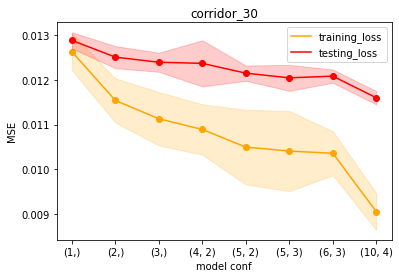

In [4]:
tr_mean, tr_std, val_mean, val_std, test_mean, test_std = get_all_result_data(corridor_30_results)
plot_results(corridor_30_results, tr_mean, tr_std, val_mean, val_std, test_mean, test_std, title="corridor_30")

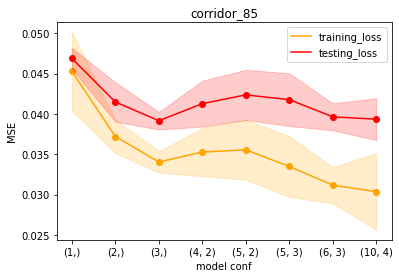

In [5]:
tr_mean, tr_std, val_mean, val_std, test_mean, test_std = get_all_result_data(corridor_85_results)
plot_results(corridor_85_results, tr_mean, tr_std, val_mean, val_std, test_mean, test_std, title="corridor_85")

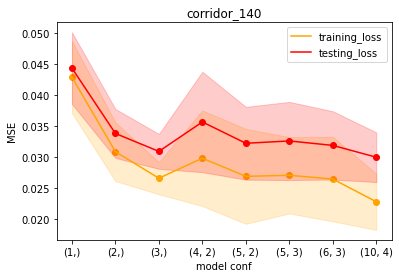

In [6]:
tr_mean, tr_std, val_mean, val_std, test_mean, test_std = get_all_result_data(corridor_140_results)
plot_results(corridor_140_results, tr_mean, tr_std, val_mean, val_std, test_mean, test_std, title="corridor_140")

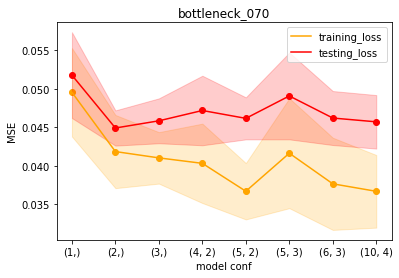

In [7]:
tr_mean, tr_std, val_mean, val_std, test_mean, test_std = get_all_result_data(bottleneck_070_results)
plot_results(bottleneck_070_results, tr_mean, tr_std, val_mean, val_std, test_mean, test_std, title="bottleneck_070")

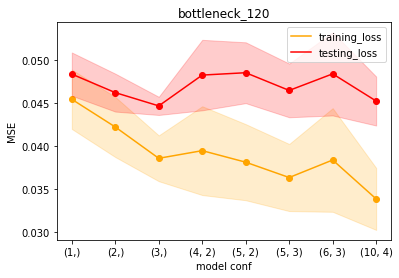

In [8]:
tr_mean, tr_std, val_mean, val_std, test_mean, test_std = get_all_result_data(bottleneck_120_results)
plot_results(bottleneck_120_results, tr_mean, tr_std, val_mean, val_std, test_mean, test_std, title="bottleneck_120")

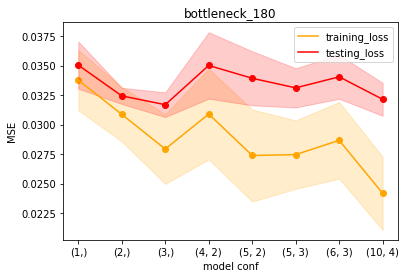

In [9]:
tr_mean, tr_std, val_mean, val_std, test_mean, test_std = get_all_result_data(bottleneck_180_results)
plot_results(bottleneck_180_results, tr_mean, tr_std, val_mean, val_std, test_mean, test_std, title="bottleneck_180")

# TRYING DIFFERENT TRAINING/TESTING SITUATIONS

In [10]:
import tensorflow as tf


class FD_Network(tf.keras.Model):
    """
    network to train a model approximating the Weidmann Model on given data
    """
    def __init__(self):
        """
        initialize the network, very simple feed forward network with 3 parameter outputs
        """
        super(FD_Network, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(3)
        # output layers producing the 3 parameters of the FD
        self.desired_speed = tf.keras.layers.Dense(1)
        self.pedestrian_size = tf.keras.layers.Dense(1)
        self.time_gap = tf.keras.layers.Dense(1)
        self.FD_model_parameters = {'t': [], 'l': [], 'v0': []}
        self.mse = -1

    def call(self, mean_spacing):
        """
        execute the feedforward, create the fd function from the parameters, return the predicted speed
        :param mean_spacing: only input of the net
        :return: predicted speed
        """
        x = self.hidden_layer(mean_spacing)
        x = tf.keras.activations.sigmoid(x)
        v0 = self.desired_speed(x)
        v0 = tf.keras.activations.softplus(v0)  # if bidirectional not needed!
        l = self.pedestrian_size(x)
        l = tf.keras.activations.softplus(l)
        t = self.time_gap(x)
        t = tf.keras.activations.softplus(t)
        self.FD_model_parameters['t'].append(tf.math.reduce_mean(t))
        self.FD_model_parameters['l'].append(tf.math.reduce_mean(l))
        self.FD_model_parameters['v0'].append(tf.math.reduce_mean(v0))
        return v0 * (1 - tf.exp((l - mean_spacing) / (v0 * t)))


In [11]:
nn_total_losses = {}
fd_total_losses = {}

In [12]:
# trying corridor85/corridor85
task = ["corridor_85"]
nn_losses, fd_losses = train_both_models(task_train=task, task_test=task)
nn_total_losses['corridor_85-corridor_85'] = nn_losses['test']
fd_total_losses['corridor_85-corridor_85'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 21ms/step - loss: 0.1500 - val_loss: 0.1185
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1160 - val_loss: 0.0942
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0942 - val_loss: 0.0789
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0802 - val_loss: 0.0704
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0717 - val_loss: 0.0657
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0670 - val_loss: 0.0630
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0618
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0623 - val_loss: 0.0610
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0611 - val_loss: 0.0606
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0604 - val_loss: 0.060

25/25 [==============================] - 0s 3ms/step - loss: 0.0536 - val_loss: 0.0525
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0525
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0525
Epoch 85/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0535 - val_loss: 0.0524
Epoch 86/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0535 - val_loss: 0.0523
Epoch 87/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0535 - val_loss: 0.0523
Epoch 88/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0523
Epoch 89/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0522
Epoch 90/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0534 - val_loss: 0.0522
Epoch 91/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0523
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0504
Epoch 163/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0505
Epoch 164/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0504
Epoch 165/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0503
Epoch 166/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0503
Epoch 167/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0522 - val_loss: 0.0504
Epoch 168/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0504
Epoch 169/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0522 - val_loss: 0.0503
Epoch 170/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0522 - val_loss: 0.0503
Epoch 171/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0522 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0496
Epoch 243/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0497
Epoch 244/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0497
Epoch 245/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0496
Epoch 246/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0497
Epoch 247/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0496
Epoch 248/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0496
Epoch 249/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0519 - val_loss: 0.0497
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0496
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0534
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0507 - val_loss: 0.0533
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0533
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0533
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0533
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0533
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0533
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0533
Epoch 8/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0507 - val_loss: 0.0533
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0533
Epoch 10/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0531
Epoch 82/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0531
Epoch 83/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0531
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0531
Epoch 85/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0531
Epoch 86/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0531
Epoch 87/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0531
Epoch 88/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0531
Epoch 89/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0531
Epoch 90/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0531
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0530
Epoch 162/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0530
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0530
Epoch 164/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0530
Epoch 165/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0530
Epoch 166/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0530
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0530
Epoch 168/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0530
Epoch 169/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0530
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0530
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0530
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0530
Epoch 244/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0530
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0530
Epoch 246/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0530
Epoch 247/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0530
Epoch 248/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0530
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0530
Epoch 250/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 322/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 324/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 325/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 326/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 327/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 328/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 330/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 402/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0529
Epoch 403/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0529
Epoch 404/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 405/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 406/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 407/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 408/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 409/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0529
Epoch 410/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0528
Epoch 482/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0528
Epoch 483/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0528
Epoch 484/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0528
Epoch 485/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0528
Epoch 486/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0528
Epoch 487/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0528
Epoch 488/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0528
Epoch 489/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0528
Epoch 490/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.

Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0511
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0511
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0511
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0508
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0512
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0500 - val_loss: 0.0378
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0378
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0379
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0379
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.037

25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0547
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0546
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0547
Epoch 54/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0546
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0547
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0547
Epoch 57/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0546
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0546
Epoch 59/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0546
Epoch 60/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0546
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0400
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0400
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0400
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0447 - val_loss: 0.0444
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0444
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0444
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0444
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0444
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0444
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0444
Epoch 8/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0503
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0503
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0432 - val_loss: 0.0503
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0503
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0508 - val_loss: 0.0510
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0509
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0509
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0509
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0509
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0509
Epoch 7/10

Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0529
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0529
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0529
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0529
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0530
Epoch 19/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0495 - val_loss: 0.0529
Epoch 20/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0496 - val_loss: 0.0529
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0529
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0529
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_los

25/25 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0544
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0544
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0543
Epoch 24/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0544
Epoch 25/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0544
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0507 - val_loss: 0.0480
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0481
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0481
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0482
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0481
Epoch 6/1

25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0522
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0523
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0522
Epoch 24/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0523
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0523
Epoch 26/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0524
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0458 - val_loss: 0.0445
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0444
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0444
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0443
Epoch 5/

25/25 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0439
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0440
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0440
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0440
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0440
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0440
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0440
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0440
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0456 - val_loss: 0.0439
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0450 - val_loss: 0.0465
Epoch 2

Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0484
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0484
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0484
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0485
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_los

25/25 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0436
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0435
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0453 - val_loss: 0.0557
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0560
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0560
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0560
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0563
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0562
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0563
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0452 - val_loss: 0.0564
Epoch 9/1000

25/25 [==============================] - 0s 3ms/step - loss: 0.0471 - val_loss: 0.0579
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0579
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0579
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0579
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0580
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0579
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0481 - val_loss: 0.0573
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0573
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0573
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0573
Epoch 5/100

Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0417
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0418
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0417
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0418
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0417
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0417
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0417
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0417
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0417
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0482 - val_loss

25/25 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0438
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0438
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0439
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0439
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0439
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0439
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0542 - val_loss: 0.0516
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0514
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0514
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0513
Epoch 5/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0502
Epoch 40/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0502
Epoch 41/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0502
Epoch 42/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0502
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0530 - val_loss: 0.0544
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0529 - val_loss: 0.0544
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0544
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0544
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0529 - val_loss: 0.0544
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0529 - val_loss: 0.0544
Epoch 7/10

25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0500
Epoch 43/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0497
Epoch 44/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0496
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0498
Epoch 46/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0497
Epoch 47/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0498
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0538 - val_loss: 0.0441
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0442
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0537 - val_loss: 0.0442
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0537 - val_loss: 0.0442
Epoch 5/

Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 0.0549
Epoch 11/1000
25/25 [==============================] - ETA: 0s - loss: 0.042 - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0549
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0549
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0549
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0549
Epoch 15/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0548 - val_loss: 0.0549
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 0.0549
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 0.0550
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0545 - val_loss: 0.0560
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - 

25/25 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0644
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0654 - val_loss: 0.0632
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0643 - val_loss: 0.0622
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0614
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0606
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0599
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0593
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0603 - val_loss: 0.0588
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0583
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0580
Epoc

Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0544
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0543
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0543
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0542
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0541
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0541
Epoch 136/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0540
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0539
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0538
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525

25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0487
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0486
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0485
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0484
Epoch 214/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0484
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0482
Epoch 216/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0481
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0481
Epoch 218/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0481
Epoch 219/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0448 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0415
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0412
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0412
Epoch 293/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0410
Epoch 294/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0411
Epoch 295/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0410
Epoch 296/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0409
Epoch 297/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0409
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0410
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0381
Epoch 371/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0381
Epoch 372/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0380
Epoch 373/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0383
Epoch 374/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0381
Epoch 375/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0379
Epoch 376/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0382
Epoch 377/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0380
Epoch 378/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0380
Epoch 379/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.1283 - val_loss: 0.0973
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1180 - val_loss: 0.0878
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1101 - val_loss: 0.0806
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1038 - val_loss: 0.0750
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0984 - val_loss: 0.0703
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0938 - val_loss: 0.0662
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0899 - val_loss: 0.0627
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0863 - val_loss: 0.0598
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0832 - val_loss: 0.0571
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0803 - val_loss: 0.0548
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0446 - val_loss: 0.0318
Epoch 93/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0446 - val_loss: 0.0318
Epoch 94/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0444 - val_loss: 0.0317
Epoch 95/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0443 - val_loss: 0.0318
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0317
Epoch 97/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0441 - val_loss: 0.0314
Epoch 98/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0439 - val_loss: 0.0314
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0316
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0312
Epoch 101/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0437 - val_loss: 0.0310
Ep

25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0279
Epoch 173/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0378 - val_loss: 0.0278
Epoch 174/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0377 - val_loss: 0.0279
Epoch 175/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0376 - val_loss: 0.0278
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0277
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0277
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0278
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0277
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0278
Epoch 181/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0372 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 1.2595 - val_loss: 1.1454
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.1390 - val_loss: 1.0363
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.0324 - val_loss: 0.9376
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.9370 - val_loss: 0.8494
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8510 - val_loss: 0.7704
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7740 - val_loss: 0.6993
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.7048 - val_loss: 0.6352
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6417 - val_loss: 0.5779
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.5856 - val_loss: 0.5259
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5345 - val_loss: 0.4790
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0422
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0422
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0421
Epoch 93/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0532 - val_loss: 0.0421
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0421
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0420
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0419
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0419
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0418
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0418
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0390
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0388
Epoch 172/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0474 - val_loss: 0.0389
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0388
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0388
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0387
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0387
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0387
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0387
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0358
Epoch 251/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0417 - val_loss: 0.0358
Epoch 252/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0358
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0357
Epoch 254/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0357
Epoch 255/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0356
Epoch 256/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0357
Epoch 257/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0355
Epoch 258/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0354
Epoch 259/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0332
Epoch 331/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0330
Epoch 332/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0331
Epoch 333/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0368 - val_loss: 0.0330
Epoch 334/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0330
Epoch 335/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0367 - val_loss: 0.0330
Epoch 336/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0329
Epoch 337/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0366 - val_loss: 0.0331
Epoch 338/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0328
Epoch 339/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0393
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0326 - val_loss: 0.0391
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0394
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0396
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0396
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0396
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0324 - val_loss: 0.0398
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.7575 - val_loss: 0.6567
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6184 - val_loss: 0.5327
Epoch 3/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.5005 - val_loss: 0.4302
Epoch 4/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0435
Epoch 76/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0469 - val_loss: 0.0435
Epoch 77/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0468 - val_loss: 0.0434
Epoch 78/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0467 - val_loss: 0.0434
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0433
Epoch 80/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0466 - val_loss: 0.0433
Epoch 81/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0432
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0432
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0431
Epoch 84/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0430
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0394
Epoch 156/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0415 - val_loss: 0.0393
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0393
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0392
Epoch 159/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0411 - val_loss: 0.0391
Epoch 160/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0411 - val_loss: 0.0390
Epoch 161/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0410 - val_loss: 0.0389
Epoch 162/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0410 - val_loss: 0.0389
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0389
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0341
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0343
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0342
Epoch 238/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0341 - val_loss: 0.0341
Epoch 239/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0341 - val_loss: 0.0340
Epoch 240/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0340 - val_loss: 0.0339
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0339
Epoch 242/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0339 - val_loss: 0.0339
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0338
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0321
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0320
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0321
Epoch 318/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0319
Epoch 319/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0320
Epoch 320/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0320
Epoch 321/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0319
Epoch 322/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0319
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0319
Epoch 324/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.7793 - val_loss: 0.7007
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6759 - val_loss: 0.6058
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5858 - val_loss: 0.5214
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5060 - val_loss: 0.4477
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4365 - val_loss: 0.3833
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3762 - val_loss: 0.3283
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3236 - val_loss: 0.2815
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2789 - val_loss: 0.2419
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2411 - val_loss: 0.2073
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2086 - val_loss: 0.1787
Epoch

25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0506
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0507
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0507
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0509
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0507
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0505
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0505
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0504
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0504
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0504
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0469
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0466
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0467
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0468
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0466
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0464
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0462
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0466
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0462
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0424
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0422
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0421
Epoch 252/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0424
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0424
Epoch 254/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0419
Epoch 255/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0423
Epoch 256/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0421
Epoch 257/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0422
Epoch 258/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0279
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0280
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0279
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0282
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0284
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0285
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0285
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0288
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0289
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0324 - val_loss: 0.0342
Epoch 2/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0494
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0495
Epoch 64/1000
25/25 [==============================] - ETA: 0s - loss: 0.052 - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0493
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0493
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0491
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0491
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0489
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0488
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0489
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411

25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0422
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0420
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0420
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0415
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0418
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0415
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0417
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0414
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0415
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0363
Epoch 223/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0366
Epoch 224/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0364
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0363
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0361
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0360
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0362
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0362
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0359
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0332
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0336
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0331
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0313 - val_loss: 0.0335
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0334
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0332
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0331
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0335
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0332
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0295
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0307 - val_loss: 0.0300
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0300
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0301
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0304
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0303
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0305
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0305 - val_loss: 0.0306
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0305
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0308
Epoch 1/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0504
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0506
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0504
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0505
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0503
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0501
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0498
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0502
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0500
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0498
Epoc

Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0467
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0468
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0464
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0466
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0470
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0464
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0466
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0463
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0467
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420

Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0390
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0389
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0389
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0379 - val_loss: 0.0487
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0492
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0497
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0499
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0504
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0504
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.05

25/25 [==============================] - 0s 3ms/step - loss: 0.0427 - val_loss: 0.0456
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0454
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0452
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0450
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0450
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0449
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0445
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0444
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0443
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0442
Epoc

Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0379
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0377
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0379
Epoch 152/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0332 - val_loss: 0.0377
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0377
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0377
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0377
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0375
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0375
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0328

25/25 [==============================] - 0s 5ms/step - loss: 0.0305 - val_loss: 0.0370
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0376
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0377
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0379
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0379
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0382
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0383
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0382
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0384
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0299 - val_loss: 0.0385
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0470
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0470
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0468
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0467
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0467
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0468
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0467
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0465
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0465
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0466
Epoc

Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0434
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.0432
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0434
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0432
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0432
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0433
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0431
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0433
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0428
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367

25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0406
Epoch 200/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0406
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0328 - val_loss: 0.0406
Epoch 202/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0406
Epoch 203/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0406
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0407
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0405
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0407
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0406
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0281
Epoch 9/1000
25/25 [==============================] - ETA: 0s - loss: 0.043 - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0281
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0282
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0282
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0320 - val_loss: 0.0336
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0337
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0343
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0343
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0345
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_

25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0520
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0514
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0512
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0511
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0508
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0505
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0505
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0503
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0500
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0499
Epoc

Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0425
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0424
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0423
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0426
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0422
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0424
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0422
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0423
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0420
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406

25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0372
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0371
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0372
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0375
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0371
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0370
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0369
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0368
Epoch 214/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0370
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0346
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0345
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0346
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0348
Epoch 290/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0346
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0345
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0346
Epoch 293/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0346
Epoch 294/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0347
Epoch 295/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0302
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0304
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0304
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.0305
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0305
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0309
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0316 - val_loss: 0.0304
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0315 - val_loss: 0.0306
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.8046 - val_loss: 0.7288
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6624 - val_loss: 0.5989
Epoch 3/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0435
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0433
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0433
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0433
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0432
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0431
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0431
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0431
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0432
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0431
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0411
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0408
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0410
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0411
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0407
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0408
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0408
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0407
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0410
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 1.1159 - val_loss: 1.1351
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.9694 - val_loss: 0.9894
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8396 - val_loss: 0.8605
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7261 - val_loss: 0.7470
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6261 - val_loss: 0.6480
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5379 - val_loss: 0.5608
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4611 - val_loss: 0.4836
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3937 - val_loss: 0.4152
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3349 - val_loss: 0.3544
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2835 - val_loss: 0.3023
Epoch 13/1

25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0511
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0511
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0511
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0511
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0511
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0512
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0510
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0509
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0509
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0509
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0484
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0486
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0482
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0484
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0483
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0483
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0483
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0480
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0482
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0449
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0446
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0446
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0447
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0449
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0444
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0445
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0444
Epoch 252/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0446
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0420
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0417
Epoch 326/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0421
Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0417
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0420
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0421
Epoch 330/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0420
Epoch 331/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0414
Epoch 332/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0417
Epoch 333/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0881 - val_loss: 0.0886
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0783 - val_loss: 0.0804
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0753
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0687 - val_loss: 0.0723
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0701
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0645 - val_loss: 0.0684
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0670
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0660
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0652
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0603 - val_loss: 0.0642
Epoch 15

25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0500
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0501
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0501
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0497
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0496
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0497
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0497
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0496
Epoch 94/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0496
Epoch 95/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0459 - val_loss: 0.0494
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0457
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0454
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0454
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0452
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0453
Epoch 171/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0404 - val_loss: 0.0454
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0452
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0452
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0451
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0416
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0414
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0418
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0415
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0414
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0414
Epoch 252/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0415
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0415
Epoch 254/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0413
Epoch 255/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0395
Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0397
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0398
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0396
Epoch 330/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0395
Epoch 331/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0397
Epoch 332/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0395
Epoch 333/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0395
Epoch 334/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0395
Epoch 335/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.

25/25 [==============================] - 0s 6ms/step - loss: 1.4565 - val_loss: 1.2431
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.2222 - val_loss: 1.0316
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.0182 - val_loss: 0.8551
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8467 - val_loss: 0.7051
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7009 - val_loss: 0.5803
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.5792 - val_loss: 0.4761
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4769 - val_loss: 0.3928
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3934 - val_loss: 0.3236
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3247 - val_loss: 0.2672
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2678 - val_loss: 0.2232
Epoch 11/100

25/25 [==============================] - 0s 5ms/step - loss: 0.0493 - val_loss: 0.0555
Epoch 83/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0493 - val_loss: 0.0555
Epoch 84/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0493 - val_loss: 0.0554
Epoch 85/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0492 - val_loss: 0.0556
Epoch 86/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0554
Epoch 87/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0490 - val_loss: 0.0553
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0552
Epoch 89/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0488 - val_loss: 0.0552
Epoch 90/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0553
Epoch 91/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0489 - val_loss: 0.0550
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0502
Epoch 163/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0431 - val_loss: 0.0501
Epoch 164/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0430 - val_loss: 0.0498
Epoch 165/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0429 - val_loss: 0.0499
Epoch 166/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0429 - val_loss: 0.0497
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0496
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0495
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0496
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0495
Epoch 171/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0424 - val_loss: 0.

25/25 [==============================] - 0s 4ms/step - loss: 0.0374 - val_loss: 0.0448
Epoch 243/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0374 - val_loss: 0.0446
Epoch 244/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0373 - val_loss: 0.0445
Epoch 245/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0373 - val_loss: 0.0445
Epoch 246/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0371 - val_loss: 0.0443
Epoch 247/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0371 - val_loss: 0.0444
Epoch 248/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0370 - val_loss: 0.0444
Epoch 249/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0370 - val_loss: 0.0444
Epoch 250/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0369 - val_loss: 0.0442
Epoch 251/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0368 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0352
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0356
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0352
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0356
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0355
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0353 - val_loss: 0.0356
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0355
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0353 - val_loss: 0.0354
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0354 - val_loss: 0.0370
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0349 - val_loss: 0.0374
Epoch 3/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0488 - val_loss: 0.0530
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0528
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0528
Epoch 55/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0525
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0523
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0521
Epoch 58/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0523
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0520
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0518
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0518
Epoc

Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0482
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0483
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0481
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0480
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0485
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0478
Epoch 139/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0407 - val_loss: 0.0478
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0478
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0479
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405

25/25 [==============================] - 0s 4ms/step - loss: 0.0370 - val_loss: 0.0461
Epoch 214/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0370 - val_loss: 0.0463
Epoch 215/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0370 - val_loss: 0.0466
Epoch 216/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0368 - val_loss: 0.0465
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0462
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0398 - val_loss: 0.0348
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0394 - val_loss: 0.0353
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0392 - val_loss: 0.0356
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0359
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0391 - val_loss: 0.0360
Epoch

In [13]:
# trying bottleneck070/bottleneck070
task = ["bottleneck_070"]
nn_losses, fd_losses = train_both_models(task_train=task, task_test=task)
nn_total_losses['bottleneck_070-bottleneck_070'] = nn_losses['test']
fd_total_losses['bottleneck_070-bottleneck_070'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0927 - val_loss: 0.0803
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0728
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0751 - val_loss: 0.0673
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0633
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0653 - val_loss: 0.0609
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0592
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0606 - val_loss: 0.0580
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0592 - val_loss: 0.0570
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0581 - val_loss: 0.0561
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0573 - val_loss: 0.0551

25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0407
Epoch 83/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0467 - val_loss: 0.0406
Epoch 84/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0467 - val_loss: 0.0405
Epoch 85/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0467 - val_loss: 0.0406
Epoch 86/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0467 - val_loss: 0.0407
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0405
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0405
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0403
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0404
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0403
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0385
Epoch 163/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0387
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0386
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0386
Epoch 166/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0459 - val_loss: 0.0386
Epoch 167/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0386
Epoch 168/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0459 - val_loss: 0.0385
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0385
Epoch 170/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0384
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0448 - val_loss: 0.0411
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0448 - val_loss: 0.0410
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0448 - val_loss: 0.0411
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0448 - val_loss: 0.0411
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0448 - val_loss: 0.0411
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0411
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0411
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0448 - val_loss: 0.0410
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0412
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0411
Epoch

25/25 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0530
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0529
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0530
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0517 - val_loss: 0.0528
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0529
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0528
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0527
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0526
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0516 - val_loss: 0.0526
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0516 - val_loss: 0.0526
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0506
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0506
Epoch 97/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0507
Epoch 98/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0506
Epoch 99/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0506
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0505
Epoch 101/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0507 - val_loss: 0.0505
Epoch 102/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0508 - val_loss: 0.0505
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0507
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0505

25/25 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0521
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0521
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0521
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0520
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0521
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0520
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0520
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0520
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0521
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0518 - val_loss: 0.0520
Epoch 14/

25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0471
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0529 - val_loss: 0.0470
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0471
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0578 - val_loss: 0.0533
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0578 - val_loss: 0.0534
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0534
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0535
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0577 - val_loss: 0.0537
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0578 - val_loss: 0.0537
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0578 - val_loss: 0.0535
Epoch 8/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0607
Epoch 1/1000
25/25 [==============================] - 1s 11ms/step - loss: 0.0480 - val_loss: 0.0515
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0479 - val_loss: 0.0514
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.0514
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0513
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.0513
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.0512
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0513
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0512
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.0512
Epoch 10/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0507
Epoch 82/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0507
Epoch 83/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0507
Epoch 84/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0507
Epoch 85/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0507
Epoch 86/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0507
Epoch 87/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0507
Epoch 88/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0506
Epoch 89/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0507
Epoch 90/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0507
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0505
Epoch 162/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0477 - val_loss: 0.0505
Epoch 163/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0505
Epoch 164/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0504
Epoch 165/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0504
Epoch 166/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0505
Epoch 167/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0504
Epoch 168/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0504
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0504
Epoch 170/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.

25/25 [==============================] - 0s 4ms/step - loss: 0.0476 - val_loss: 0.0503
Epoch 242/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0502
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0502
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0503
Epoch 245/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0502
Epoch 246/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0503
Epoch 247/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0475 - val_loss: 0.0502
Epoch 248/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0502
Epoch 249/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0502
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.

Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0551
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0550
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0551
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0551
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0551
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0551
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0551
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0550
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0551
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 

25/25 [==============================] - 1s 9ms/step - loss: 0.0495 - val_loss: 0.0354
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0353
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0352
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0353
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0353
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0352
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0352
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0353
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0353
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0352
Epoch 11/100

Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0393
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0488 - val_loss: 0.0393
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0393
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0393
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0393
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0392
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0393
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0393
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0392
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_los

25/25 [==============================] - 0s 3ms/step - loss: 0.0468 - val_loss: 0.0456
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0459 - val_loss: 0.0496
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0496
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0496
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0496
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0496
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0496
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0496
Epoch 8/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0458 - val_loss: 0.0496
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0458 - val_loss: 0.0496
Epoch 10/1000

25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0477
Epoch 1/1000
25/25 [==============================] - 1s 10ms/step - loss: 0.0475 - val_loss: 0.0428
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0428
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0428
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0475 - val_loss: 0.0428
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0428
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0474 - val_loss: 0.0428
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0428
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0474 - val_loss: 0.0428
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0474 - val_loss: 0.0428
Epoch 10/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 67/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 68/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 69/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 70/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 71/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 72/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 74/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 75/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0469
Epoc

Epoch 147/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 148/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 151/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0462 - val_loss: 0.0469
Epoch 152/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 153/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 154/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0469
Epoch 155/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 156/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0463

25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0469
Epoch 228/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 229/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 230/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 231/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 232/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 233/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 234/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 235/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 236/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0462 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 308/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 309/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 310/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 311/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 312/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 313/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 314/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 315/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 316/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 388/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 389/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 390/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 391/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 392/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 393/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 394/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0468
Epoch 395/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 396/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.

25/25 [==============================] - 0s 4ms/step - loss: 0.0462 - val_loss: 0.0467
Epoch 468/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 469/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0462 - val_loss: 0.0467
Epoch 470/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0468
Epoch 471/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0467
Epoch 472/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0467
Epoch 473/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 474/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 475/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 476/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 548/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 549/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 550/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 551/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 552/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 553/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 554/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 555/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 556/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 628/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 629/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 630/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 631/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 632/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 633/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 634/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 635/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0467
Epoch 636/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0461 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 708/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 709/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 710/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 711/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 712/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 713/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 714/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 715/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 716/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0467
Epoch 788/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 789/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 790/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 791/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 792/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 793/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 794/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 795/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0467
Epoch 796/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0460 - val_loss: 0.

25/25 [==============================] - 0s 4ms/step - loss: 0.0460 - val_loss: 0.0466
Epoch 868/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0466
Epoch 869/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0460 - val_loss: 0.0466
Epoch 870/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0466
Epoch 871/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0466
Epoch 872/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0466
Epoch 873/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0466
Epoch 874/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0466
Epoch 875/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0461 - val_loss: 0.0466
Epoch 876/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0466
Epoch 948/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0466
Epoch 949/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0466
Epoch 950/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0460 - val_loss: 0.0466
Epoch 951/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0466
Epoch 952/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0460 - val_loss: 0.0466
Epoch 953/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0466
Epoch 954/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0466
Epoch 955/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0466
Epoch 956/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.

Epoch 6/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0487 - val_loss: 0.0441
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0441
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0441
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0441
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0488 - val_loss: 0.0441
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0442
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0478 - val_loss: 0.0483
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0481
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0477 - val_loss: 0.0482
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0477 - val_loss: 0.048

25/25 [==============================] - 0s 5ms/step - loss: 0.0464 - val_loss: 0.0519
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0471 - val_loss: 0.0493
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0471 - val_loss: 0.0494
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0494
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0471 - val_loss: 0.0495
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0470 - val_loss: 0.0495
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0496
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0470 - val_loss: 0.0496
Epoch 8/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0470 - val_loss: 0.0496
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0470 - val_loss: 0.0497
Epoch 10/1000

25/25 [==============================] - 0s 4ms/step - loss: 0.0559 - val_loss: 0.0503
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.0502
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0556 - val_loss: 0.0502
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0555 - val_loss: 0.0502
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0554 - val_loss: 0.0502
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0553 - val_loss: 0.0502
Epoch 8/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0552 - val_loss: 0.0502
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0551 - val_loss: 0.0502
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0551 - val_loss: 0.0502
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0550 - val_loss: 0.0502
Epoch 12/10

25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0405
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0405
Epoch 22/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0481 - val_loss: 0.0405
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0404
Epoch 24/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0404
Epoch 25/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0405
Epoch 26/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0404
Epoch 27/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0404
Epoch 28/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.0404
Epoch 29/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.0404
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0417
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0417
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0497 - val_loss: 0.0416
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0416
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0497 - val_loss: 0.0416
Epoch 8/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0496 - val_loss: 0.0415
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0415
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0414
Epoch 11/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0495 - val_loss: 0.0415
Epoch 12/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0495 - val_loss: 0.0414
Epoch 13/1

25/25 [==============================] - 0s 4ms/step - loss: 0.0493 - val_loss: 0.0411
Epoch 85/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0411
Epoch 86/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0411
Epoch 87/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0411
Epoch 88/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0411
Epoch 89/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0411
Epoch 90/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0411
Epoch 91/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0411
Epoch 92/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0411
Epoch 93/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0411
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0951
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0745 - val_loss: 0.0942
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0739 - val_loss: 0.0935
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.0925
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0727 - val_loss: 0.0921
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0723 - val_loss: 0.0913
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0718 - val_loss: 0.0906
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0897
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0707 - val_loss: 0.0889
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0887
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0592
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0590
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0585
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0584
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0581
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0580
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0579
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0574
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0574
Epoch 106/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.05

25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0514
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0517
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0513
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0514
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0512
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0518
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0514
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0513
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0515
Epoch 186/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0464 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0458
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0459
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0451 - val_loss: 0.0459
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0459
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0461
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0462
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0891 - val_loss: 0.1078
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0834 - val_loss: 0.1036
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0801 - val_loss: 0.1011
Epoch 4/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0778 - val_loss: 0.0995
Epoch 5/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0677
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0676
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0672
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0669
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0665
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0664
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0658
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0659
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0653
Epoch 85/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0475 - val_loss: 0.0653
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0526
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0522
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0525
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0522
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0519
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0522
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0520
Epoch 163/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0388 - val_loss: 0.0521
Epoch 164/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0389 - val_loss: 0.0520
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0490
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0490
Epoch 238/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0363 - val_loss: 0.0485
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0487
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0488
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0487
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0488
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0487
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0484
Epoch 245/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0350
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0350
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0353
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0352
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0353
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0355
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.0361 - val_loss: 0.0417
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0420
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0423
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0425
Epoch 5/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0674
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0648 - val_loss: 0.0673
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0671
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0645 - val_loss: 0.0670
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0669
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0667
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0641 - val_loss: 0.0666
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0665
Epoch 51/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0639 - val_loss: 0.0664
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0637 - val_loss: 0.0663
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0570
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0569
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0567
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0566
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0565
Epoch 129/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0550 - val_loss: 0.0562
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0550 - val_loss: 0.0562
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0560
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0558
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0446
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0445
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0444
Epoch 207/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0448 - val_loss: 0.0442
Epoch 208/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0442
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0441
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0439
Epoch 211/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0444 - val_loss: 0.0437
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0436
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0396 - val_loss: 0.0383
Epoch 285/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0396 - val_loss: 0.0383
Epoch 286/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0394 - val_loss: 0.0382
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0381
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0381
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0381
Epoch 290/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0382
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0381
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0381
Epoch 293/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0392 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0465
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0344 - val_loss: 0.0468
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0471
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0472
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0343 - val_loss: 0.0470
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0343 - val_loss: 0.0474
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.5078 - val_loss: 0.3991
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4059 - val_loss: 0.3149
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.3241 - val_loss: 0.2516
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.2628 - val_loss: 0.2024
Epoch 5/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0635 - val_loss: 0.0549
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0547
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.0541
Epoch 79/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0629 - val_loss: 0.0540
Epoch 80/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0625 - val_loss: 0.0539
Epoch 81/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0623 - val_loss: 0.0537
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0535
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0532
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0529
Epoch 85/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0614 - val_loss: 0.0528
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0487 - val_loss: 0.0432
Epoch 157/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0486 - val_loss: 0.0430
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0431
Epoch 159/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0429
Epoch 160/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0427
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0432
Epoch 162/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0426
Epoch 163/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0429
Epoch 164/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0425
Epoch 165/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0479 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0950 - val_loss: 0.0925
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0924 - val_loss: 0.0902
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0901 - val_loss: 0.0881
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0877 - val_loss: 0.0862
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0858 - val_loss: 0.0844
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0841 - val_loss: 0.0829
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0825 - val_loss: 0.0821
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0811 - val_loss: 0.0806
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0798 - val_loss: 0.0796
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0787 - val_loss: 0.0786
Epoch 

25/25 [==============================] - 0s 3ms/step - loss: 0.0549 - val_loss: 0.0568
Epoch 89/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0561
Epoch 90/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0546 - val_loss: 0.0560
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0558
Epoch 92/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0560
Epoch 93/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0539 - val_loss: 0.0556
Epoch 94/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0537 - val_loss: 0.0556
Epoch 95/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0536 - val_loss: 0.0553
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0548
Epoch 97/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.0551
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0449 - val_loss: 0.0489
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0493
Epoch 170/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0448 - val_loss: 0.0489
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0490
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0489
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0489
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0490
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0489
Epoch 176/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0446 - val_loss: 0.0488
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0435 - val_loss: 0.0414
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0415
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0417
Epoch 1/1000
25/25 [==============================] - 1s 13ms/step - loss: 0.0437 - val_loss: 0.0410
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0433 - val_loss: 0.0416
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0433 - val_loss: 0.0419
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0431 - val_loss: 0.0423
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0425
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0429 - val_loss: 0.0427
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0429
Epoch 8/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0835 - val_loss: 0.0838
Epoch 69/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0834 - val_loss: 0.0835
Epoch 70/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.0835
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.0834
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0828 - val_loss: 0.0831
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0827 - val_loss: 0.0829
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0826 - val_loss: 0.0828
Epoch 75/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0824 - val_loss: 0.0826
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0821 - val_loss: 0.0823
Epoch 77/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0821 - val_loss: 0.0822
Epoc

Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0668
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0658 - val_loss: 0.0664
Epoch 151/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0656 - val_loss: 0.0662
Epoch 152/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0653 - val_loss: 0.0660
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0659
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0649 - val_loss: 0.0656
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.0653
Epoch 156/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0644 - val_loss: 0.0651
Epoch 157/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0642 - val_loss: 0.0649
Epoch 158/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0640

25/25 [==============================] - 0s 3ms/step - loss: 0.0534 - val_loss: 0.0563
Epoch 230/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0562
Epoch 231/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0563
Epoch 232/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0532 - val_loss: 0.0561
Epoch 233/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0531 - val_loss: 0.0562
Epoch 234/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0562
Epoch 235/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0529 - val_loss: 0.0564
Epoch 236/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0528 - val_loss: 0.0562
Epoch 237/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0529 - val_loss: 0.0561
Epoch 238/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0527 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.1917 - val_loss: 0.1636
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1691 - val_loss: 0.1454
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1503 - val_loss: 0.1304
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1346 - val_loss: 0.1182
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1218 - val_loss: 0.1084
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1114 - val_loss: 0.1004
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1029 - val_loss: 0.0942
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0961 - val_loss: 0.0891
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0905 - val_loss: 0.0853
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0861 - val_loss: 0.0822
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0663
Epoch 99/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0635 - val_loss: 0.0662
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0661
Epoch 101/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0632 - val_loss: 0.0659
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.0658
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0630 - val_loss: 0.0657
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0629 - val_loss: 0.0656
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0655
Epoch 106/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0654
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0626 - val_loss: 0.0

25/25 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0534
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0532
Epoch 180/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0529
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0527
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0525
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0525
Epoch 184/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0520 - val_loss: 0.0522
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0522
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0518
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0448 - val_loss: 0.0438
Epoch 259/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0441
Epoch 260/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0446 - val_loss: 0.0438
Epoch 261/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0438
Epoch 262/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0446 - val_loss: 0.0437
Epoch 263/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0445 - val_loss: 0.0438
Epoch 264/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0444 - val_loss: 0.0437
Epoch 265/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0444 - val_loss: 0.0437
Epoch 266/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0443 - val_loss: 0.0437
Epoch 267/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0442 - val_loss: 0.

25/25 [==============================] - 0s 7ms/step - loss: 0.8613 - val_loss: 0.7788
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7458 - val_loss: 0.6704
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.6423 - val_loss: 0.5755
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.5526 - val_loss: 0.4903
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4729 - val_loss: 0.4166
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4040 - val_loss: 0.3538
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3442 - val_loss: 0.3015
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.2942 - val_loss: 0.2561
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.2513 - val_loss: 0.2184
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2155 - val_loss: 0.1881
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0678 - val_loss: 0.0715
Epoch 83/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0677 - val_loss: 0.0713
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0675 - val_loss: 0.0713
Epoch 85/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0672 - val_loss: 0.0709
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0670 - val_loss: 0.0710
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0707
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.0704
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.0705
Epoch 90/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0662 - val_loss: 0.0704
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0660 - val_loss: 0.0700
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0559
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0557
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0555
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0553
Epoch 166/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0484 - val_loss: 0.0551
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0552
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0550
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0549
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0548
Epoch 171/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0474 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0496
Epoch 243/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0398 - val_loss: 0.0496
Epoch 244/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0397 - val_loss: 0.0494
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0490
Epoch 246/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0396 - val_loss: 0.0493
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0491
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0490
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0490
Epoch 250/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0394 - val_loss: 0.0488
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0439
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0436
Epoch 324/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0438
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0434
Epoch 326/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0437
Epoch 327/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0354 - val_loss: 0.0436
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0435
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0433
Epoch 330/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0435
Epoch 331/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0334
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0368 - val_loss: 0.0304
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0309
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0310
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0311
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0317
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0358 - val_loss: 0.0314
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0318
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0320
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0319
Epoch 10/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0555
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0553
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0552
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0548
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0548
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0548
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.0545
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0542
Epoch 78/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0510 - val_loss: 0.0543
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0539
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0483
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0481
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0481
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0479
Epoch 154/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0435 - val_loss: 0.0481
Epoch 155/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0435 - val_loss: 0.0481
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0479
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0479
Epoch 158/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0479
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0459
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0458
Epoch 232/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0406 - val_loss: 0.0459
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0457
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0458
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0457
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0456
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0456
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0458
Epoch 239/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0404 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0393 - val_loss: 0.0440
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0438
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0439
Epoch 313/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0391 - val_loss: 0.0439
Epoch 314/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0391 - val_loss: 0.0438
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0438
Epoch 316/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0391 - val_loss: 0.0439
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0436
Epoch 318/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0391 - val_loss: 0.0437
Epoch 319/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0391 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0422
Epoch 391/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384 - val_loss: 0.0422
Epoch 392/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0422
Epoch 393/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0420
Epoch 394/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0383 - val_loss: 0.0420
Epoch 395/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0383 - val_loss: 0.0420
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0369 - val_loss: 0.0482
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0490
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0363 - val_loss: 0.0490
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0489
Epo

25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0585
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0687 - val_loss: 0.0582
Epoch 34/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0682 - val_loss: 0.0578
Epoch 35/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0678 - val_loss: 0.0575
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0674 - val_loss: 0.0575
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0670 - val_loss: 0.0572
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.0570
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0570
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0660 - val_loss: 0.0567
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0657 - val_loss: 0.0567
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0519
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0517
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0559 - val_loss: 0.0517
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0559 - val_loss: 0.0516
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0557 - val_loss: 0.0517
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0515
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0513
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0514
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0512
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0550 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0470
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0471
Epoch 195/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0451 - val_loss: 0.0474
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0471
Epoch 197/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0472
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0468
Epoch 199/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0469
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0426 - val_loss: 0.0556
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0421 - val_loss: 0.0560
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0419 - val_loss: 0.0568
E

25/25 [==============================] - 0s 3ms/step - loss: 0.0725 - val_loss: 0.1016
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0722 - val_loss: 0.1014
Epoch 33/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0719 - val_loss: 0.1011
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0715 - val_loss: 0.1010
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0712 - val_loss: 0.1007
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0709 - val_loss: 0.1005
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0705 - val_loss: 0.1000
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0998
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0997
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0697 - val_loss: 0.0996
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0511 - val_loss: 0.0766
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0760
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0757
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0758
Epoch 116/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0752
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0755
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0751
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0749
Epoch 120/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0747
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0676
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0678
Epoch 194/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0440 - val_loss: 0.0678
Epoch 195/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0439 - val_loss: 0.0678
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0675
Epoch 197/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0438 - val_loss: 0.0675
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0674
Epoch 199/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0437 - val_loss: 0.0674
Epoch 200/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0437 - val_loss: 0.0673
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0414 - val_loss: 0.0642
Epoch 273/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0414 - val_loss: 0.0642
Epoch 274/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0414 - val_loss: 0.0637
Epoch 275/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0413 - val_loss: 0.0642
Epoch 276/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0413 - val_loss: 0.0638
Epoch 277/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0412 - val_loss: 0.0638
Epoch 278/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0412 - val_loss: 0.0637
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0640
Epoch 280/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0412 - val_loss: 0.0634
Epoch 281/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0411 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0400 - val_loss: 0.0614
Epoch 353/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0400 - val_loss: 0.0615
Epoch 354/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0614
Epoch 355/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0400 - val_loss: 0.0613
Epoch 356/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0400 - val_loss: 0.0611
Epoch 357/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0400 - val_loss: 0.0615
Epoch 358/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0399 - val_loss: 0.0611
Epoch 359/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0399 - val_loss: 0.0612
Epoch 360/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0613
Epoch 361/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0399 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0392 - val_loss: 0.0597
Epoch 433/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0392 - val_loss: 0.0596
Epoch 434/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0596
Epoch 435/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0598
Epoch 436/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0393 - val_loss: 0.0595
Epoch 437/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0392 - val_loss: 0.0597
Epoch 438/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0594
Epoch 439/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0593
Epoch 440/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0600
Epoch 441/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0369
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0375
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0373
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0435 - val_loss: 0.0375
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0377
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0379
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0430 - val_loss: 0.0402
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0411
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0412
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0415
Epoch 5/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0742 - val_loss: 0.0728
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0740 - val_loss: 0.0727
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0737 - val_loss: 0.0725
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0735 - val_loss: 0.0724
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.0722
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0731 - val_loss: 0.0720
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0728 - val_loss: 0.0718
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0716
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.0715
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0722 - val_loss: 0.0712
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0482
Epoch 125/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0542 - val_loss: 0.0480
Epoch 126/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0542 - val_loss: 0.0479
Epoch 127/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0475
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0471
Epoch 129/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0535 - val_loss: 0.0469
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0468
Epoch 131/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0530 - val_loss: 0.0463
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0460
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0375
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0373
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0373
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0372
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0372
Epoch 209/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0372
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0371
Epoch 211/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0446 - val_loss: 0.0370
Epoch 212/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0447 - val_loss: 0.0371
Epoch 213/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0446 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0340
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0343
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0341
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0412 - val_loss: 0.0342
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0412 - val_loss: 0.0345
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0410 - val_loss: 0.0344
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0345
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0346
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0346
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0384 - val_loss: 0.0454
Epoch 2/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0681
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0680
Epoch 63/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0621 - val_loss: 0.0678
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0675
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0679
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.0672
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0671
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0668
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0604 - val_loss: 0.0671
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0664
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0603
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0604
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0598
Epoch 144/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0602
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0603
Epoch 146/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0490 - val_loss: 0.0602
Epoch 147/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0491 - val_loss: 0.0599
Epoch 148/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0489 - val_loss: 0.0598
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0597
Epoch 150/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0488 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0558
Epoch 222/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0557
Epoch 223/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0559
Epoch 224/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0559
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0557
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0554
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0551
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0556
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0554
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.

Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0400
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0400
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0399
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0425 - val_loss: 0.0473
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0477
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0476
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0478
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0478
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0479
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.048

25/25 [==============================] - 0s 2ms/step - loss: 0.0691 - val_loss: 0.0824
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0690 - val_loss: 0.0822
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0689 - val_loss: 0.0821
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0688 - val_loss: 0.0821
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0686 - val_loss: 0.0820
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0685 - val_loss: 0.0818
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0683 - val_loss: 0.0818
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0682 - val_loss: 0.0817
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0681 - val_loss: 0.0816
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0680 - val_loss: 0.0814
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0673
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0670
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0668
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0665
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0559 - val_loss: 0.0661
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0660
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0656
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0655
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0550 - val_loss: 0.0651
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0500
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0497
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0495
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0495
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0493
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0493
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0491
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0490
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0490
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0457
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0456
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0455
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0456
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0456
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0455
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0457
Epoch 315/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0399 - val_loss: 0.0454
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0455
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0696 - val_loss: 0.1001
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0687 - val_loss: 0.0995
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0680 - val_loss: 0.0982
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0672 - val_loss: 0.0974
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.0971
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0659 - val_loss: 0.0962
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0653 - val_loss: 0.0953
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0649 - val_loss: 0.0939
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0938
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0930
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0664
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0656
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0662
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0655
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0652
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0650
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0645
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0642
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0642
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.06

25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0571
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0569
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0572
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0572
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0566
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0569
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0566
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0567
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0570
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.

In [14]:
# trying corridor85/bottleneck070
task_train = ["corridor_85"]
task_test = ["bottleneck_070"]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses['corridor_85-bottleneck_070'] = nn_losses['test']
fd_total_losses['corridor_85-bottleneck_070'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 21.2088 - val_loss: 12.4667
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 7.6087 - val_loss: 6.7964
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 4.7838 - val_loss: 4.7980
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 3.5866 - val_loss: 3.7117
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.8532 - val_loss: 3.0786
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.4017 - val_loss: 2.5921
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.0582 - val_loss: 2.2454
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.8036 - val_loss: 1.9811
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.6037 - val_loss: 1.7746
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.4458 - val_loss: 1.60

25/25 [==============================] - 0s 2ms/step - loss: 0.1814 - val_loss: 0.2055
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1793 - val_loss: 0.2030
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1771 - val_loss: 0.2006
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1751 - val_loss: 0.1983
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1730 - val_loss: 0.1960
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1710 - val_loss: 0.1938
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1691 - val_loss: 0.1916
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1672 - val_loss: 0.1894
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1653 - val_loss: 0.1873
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1635 - val_loss: 0.1852
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0850 - val_loss: 0.0982
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0843 - val_loss: 0.0974
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0837 - val_loss: 0.0967
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0959
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0823 - val_loss: 0.0952
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0817 - val_loss: 0.0945
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0810 - val_loss: 0.0938
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.0931
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0798 - val_loss: 0.0924
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0651
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0650
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0649
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0648
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0647
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0646
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0645
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0644
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0643
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0617
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0617
Epoch 324/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0617
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0617
Epoch 326/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0617
Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0616
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0616
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0616
Epoch 330/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0616
Epoch 331/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0604
Epoch 403/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0604
Epoch 404/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0604
Epoch 405/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0604
Epoch 406/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0604
Epoch 407/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0603
Epoch 408/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0603
Epoch 409/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0603
Epoch 410/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0603
Epoch 411/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0589
Epoch 483/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0589
Epoch 484/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0589
Epoch 485/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0588
Epoch 486/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0588
Epoch 487/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0588
Epoch 488/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0588
Epoch 489/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0588
Epoch 490/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0587
Epoch 491/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0573
Epoch 563/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0573
Epoch 564/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0573
Epoch 565/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0573
Epoch 566/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0573
Epoch 567/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0572
Epoch 568/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0572
Epoch 569/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0572
Epoch 570/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0572
Epoch 571/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0563
Epoch 643/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0563
Epoch 644/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0563
Epoch 645/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0563
Epoch 646/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0563
Epoch 647/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0563
Epoch 648/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0563
Epoch 649/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0563
Epoch 650/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0563
Epoch 651/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0558
Epoch 723/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0558
Epoch 724/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0558
Epoch 725/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0558
Epoch 726/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0558
Epoch 727/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0558
Epoch 728/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0558
Epoch 729/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0558
Epoch 730/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0558
Epoch 731/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0556
Epoch 803/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0556
Epoch 804/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0556
Epoch 805/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0556
Epoch 806/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0556
Epoch 807/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0556
Epoch 808/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0556
Epoch 809/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0556
Epoch 810/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0556
Epoch 811/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0555
Epoch 883/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0555
Epoch 884/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0555
Epoch 885/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0555
Epoch 886/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0555
Epoch 887/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0555
Epoch 888/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0555
Epoch 889/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0555
Epoch 890/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0555
Epoch 891/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0554
Epoch 963/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0554
Epoch 964/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0554
Epoch 965/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0554
Epoch 966/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0554
Epoch 967/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0554
Epoch 968/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0554
Epoch 969/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0554
Epoch 970/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0554
Epoch 971/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0457
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0457
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0457
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0457
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0457
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0457
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0457
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0457
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0455 - val_loss: 0.0426
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0425
Epoch 3/100

25/25 [==============================] - 1s 7ms/step - loss: 0.0458 - val_loss: 0.0354
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0354
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0354
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0355
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0355
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0354
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0354
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0354
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0354
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0354
Epoch 11/100

Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0529
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0529
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0489 - val_loss: 0.0454
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0455
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0455
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0455
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0455
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0489 - val_loss: 0.0455
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0489 - val_loss: 0.0455
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.045

25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0462
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0463
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0463 - val_loss: 0.0516
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0517
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0517
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0517
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0517
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0517
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0518
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0518
Epoch 9/1000

Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0549
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0550
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0550
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0550
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0549
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0550
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0549
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0550
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0550
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_los

25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0584
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0584
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0584
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0585
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0585
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0585
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0585
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0585
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0585
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0489 - val_loss: 0.0482
Epoch 2/100

Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0597
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0598
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0597
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0597
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0597
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0597
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0597
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0597
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0518 - val_loss: 0.0497
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0517 - val_loss: 0.049

25/25 [==============================] - 0s 3ms/step - loss: 0.0450 - val_loss: 0.0495
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0450 - val_loss: 0.0495
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0450 - val_loss: 0.0495
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0450 - val_loss: 0.0495
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0450 - val_loss: 0.0495
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0450 - val_loss: 0.0495
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0450 - val_loss: 0.0495
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0499 - val_loss: 0.0577
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0578
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0579
Epoch 4

25/25 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0466
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0465
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0466
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0465
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0465
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0465
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0466
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0466
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0521 - val_loss: 0.0489
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0521 - val_loss: 0.0489
Epoch 3/10

Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0461
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0462
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0461
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0461
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0461
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0517 - val_loss: 0.0438
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0516 - val_loss: 0.0438
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0516 - val_loss: 0.0439
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0516 - val_loss: 0.0439
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0516 - val_loss: 0.043

25/25 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0529
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0529
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0529
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0529
Epoch 24/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0529
Epoch 25/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0529
Epoch 26/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0529
Epoch 27/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0529
Epoch 28/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0529
Epoch 29/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.0529
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0445 - val_loss: 0.0455
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0445 - val_loss: 0.0455
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0445 - val_loss: 0.0456
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0431 - val_loss: 0.0511
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0431 - val_loss: 0.0511
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0431 - val_loss: 0.0511
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0430 - val_loss: 0.0511
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0511
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0511
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0431 - val_loss: 0.0511
Epoch 8/100

Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0417 - val_loss: 0.0416
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0417 - val_loss: 0.0416
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0417 - val_loss: 0.0416
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0417 - val_loss: 0.0416
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0417 - val_loss: 0.0416
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0417 - val_loss: 0.0416
Epoch 23/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0417 - val_loss: 0.0416
Epoch 24/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0417 - val_loss: 0.0416
Epoch 25/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0417 - val_loss: 0.0416
Epoch 26/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0417 - val_los

25/25 [==============================] - 0s 3ms/step - loss: 0.3492 - val_loss: 0.3398
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2906 - val_loss: 0.2859
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.2423 - val_loss: 0.2415
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2029 - val_loss: 0.2039
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1704 - val_loss: 0.1734
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1441 - val_loss: 0.1490
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1232 - val_loss: 0.1292
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1064 - val_loss: 0.1135
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0935 - val_loss: 0.1009
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.0911
Epoch 

25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0556
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0555
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0554
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0554
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0554
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0553
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0553
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0552
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0551
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0551
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0486
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0486
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0485
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0483
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0483
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0482
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0481
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0480
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0479
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0430
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0429
Epoch 250/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0389 - val_loss: 0.0430
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0429
Epoch 252/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0390 - val_loss: 0.0429
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0428
Epoch 254/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0427
Epoch 255/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.0427
Epoch 256/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0428
Epoch 257/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0401
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0399
Epoch 330/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0400
Epoch 331/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0402
Epoch 332/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0401
Epoch 333/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0399
Epoch 334/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0400
Epoch 335/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0400
Epoch 336/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0399
Epoch 337/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0382
Epoch 409/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0382
Epoch 410/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0382
Epoch 411/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0380
Epoch 412/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0381
Epoch 413/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0379
Epoch 414/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0346 - val_loss: 0.0381
Epoch 415/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0381
Epoch 416/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0346 - val_loss: 0.0380
Epoch 417/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0377
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0333 - val_loss: 0.0378
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.1852 - val_loss: 0.1460
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1534 - val_loss: 0.1189
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1303 - val_loss: 0.0993
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1131 - val_loss: 0.0849
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0992 - val_loss: 0.0744
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0882 - val_loss: 0.0663
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0793 - val_loss: 0.0606
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0567
Epoch 9/1000

25/25 [==============================] - 0s 3ms/step - loss: 0.0404 - val_loss: 0.0355
Epoch 81/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0403 - val_loss: 0.0355
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0352
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0352
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0350
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0351
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0347
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0350
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0346
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0348
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0344 - val_loss: 0.0303
Epoch 161/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0343 - val_loss: 0.0304
Epoch 162/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0343 - val_loss: 0.0303
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0304
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0302
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0300
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0302
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0301
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0302
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0288 - val_loss: 0.0403
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0404
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0286 - val_loss: 0.0406
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0285 - val_loss: 0.0409
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0410
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0408
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0285 - val_loss: 0.0411
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0283 - val_loss: 0.0411
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0283 - val_loss: 0.0413
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0283 - val_loss: 0.0414
Epoch 1/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0544
Epoch 51/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0484 - val_loss: 0.0544
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0541
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0541
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0536
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0537
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0533
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0534
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0533
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0532
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0408 - val_loss: 0.0460
Epoch 131/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0408 - val_loss: 0.0461
Epoch 132/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0409 - val_loss: 0.0460
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0458
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0458
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0458
Epoch 136/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0404 - val_loss: 0.0457
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0458
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0455
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0369 - val_loss: 0.0428
Epoch 211/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0367 - val_loss: 0.0426
Epoch 212/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0368 - val_loss: 0.0428
Epoch 213/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0367 - val_loss: 0.0425
Epoch 214/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0366 - val_loss: 0.0428
Epoch 215/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0366 - val_loss: 0.0425
Epoch 216/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0367 - val_loss: 0.0428
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0426
Epoch 218/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0423
Epoch 219/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0364 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0395
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0351 - val_loss: 0.0392
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0396
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0397
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0348 - val_loss: 0.0396
Epoch 1/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0367 - val_loss: 0.0328
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0363 - val_loss: 0.0331
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.0337
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0338
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0337
Epoch 6/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0595
Epoch 43/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0614 - val_loss: 0.0592
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0596
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0593
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0593
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0603 - val_loss: 0.0596
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0593
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0591
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0596
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0594
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0564
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0565
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0560
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0561
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0559
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0557
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0557
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0558
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0556
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0491
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0490
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0493
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0492
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0489
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0485
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0487
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0486
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0484
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0430
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0432
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0434
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0429
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0431
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0429
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0428
Epoch 290/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0428
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0429
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0327 - val_loss: 0.0409
Epoch 364/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0408
Epoch 365/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0405
Epoch 366/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0408
Epoch 367/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0408
Epoch 368/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0406
Epoch 369/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0407
Epoch 370/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0408
Epoch 371/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0408
Epoch 372/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0356
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0354
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0357
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0335 - val_loss: 0.0308
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0313
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0311
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0316
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0318
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0315
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0317
Epoch 8/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0488
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0487
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0486
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0485
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0483
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0482
Epoch 52/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0442 - val_loss: 0.0481
Epoch 53/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0443 - val_loss: 0.0481
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0479
Epoch 55/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0439 - val_loss: 0.0478
Epoc

Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0431
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0430
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0429
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0431
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0429
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0429
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - val_loss: 0.0428
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0428
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0429
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377

25/25 [==============================] - 0s 3ms/step - loss: 0.0353 - val_loss: 0.0414
Epoch 208/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0352 - val_loss: 0.0414
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0413
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0414
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0412
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0413
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0414
Epoch 214/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0350 - val_loss: 0.0413
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0413
Epoch 216/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.

25/25 [==============================] - 0s 6ms/step - loss: 0.2176 - val_loss: 0.1847
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1626 - val_loss: 0.1316
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1263 - val_loss: 0.0978
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1027 - val_loss: 0.0829
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0891 - val_loss: 0.0751
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.0696
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0745 - val_loss: 0.0661
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0698 - val_loss: 0.0632
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0612
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0595
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0384
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0386
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0385
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0382
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0382
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0382
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0379
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0382
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0379
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0377
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0356
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0356
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0353
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0354
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0356
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0353
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0353
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0356
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0351
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.

25/25 [==============================] - 0s 6ms/step - loss: 1.9756 - val_loss: 1.8068
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.7444 - val_loss: 1.5979
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.5402 - val_loss: 1.4176
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.3632 - val_loss: 1.2588
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.2078 - val_loss: 1.1191
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.0721 - val_loss: 0.9958
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.9527 - val_loss: 0.8866
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8474 - val_loss: 0.7899
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7547 - val_loss: 0.7046
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6720 - val_loss: 0.6286
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0460
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0461
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0460
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0459
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0458
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0459
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0458
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0459
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0457
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0457
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0428
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0427
Epoch 164/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0424 - val_loss: 0.0427
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0426
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0426
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0425
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0424
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0423
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0421
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0383
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0384
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0382
Epoch 245/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0362 - val_loss: 0.0379
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0381
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0379
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0380
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0377
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0380
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.

Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0338 - val_loss: 0.0307
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0308
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0312
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0313
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0314
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0334 - val_loss: 0.0317
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0317
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0319
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0320
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.032

25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0442
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0441
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0438
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0439
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0446 - val_loss: 0.0436
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0436
Epoch 67/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0443 - val_loss: 0.0430
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0432
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0428
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0430
Epoc

25/25 [==============================] - 0s 8ms/step - loss: 0.0364 - val_loss: 0.0336
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0339
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0341
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0345
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0347
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0350
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0353
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0353
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0355
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0358
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0467
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0469
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0464
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0464
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0464
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0461
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0460
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0459
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0458
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0459
Epoc

Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0403
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0400
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0400
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0402
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0400
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0400
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0398
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0397
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0396
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416

25/25 [==============================] - 0s 3ms/step - loss: 0.0350 - val_loss: 0.0369
Epoch 211/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0350 - val_loss: 0.0367
Epoch 212/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0349 - val_loss: 0.0369
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0368
Epoch 214/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0370
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0368
Epoch 216/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0369
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0368
Epoch 218/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0347 - val_loss: 0.0368
Epoch 219/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0603 - val_loss: 0.0516
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0514
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0513
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0513
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0508
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0508
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0506
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0507
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0502
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0501
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0425
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0423
Epoch 109/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0475 - val_loss: 0.0424
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0425
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0421
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0422
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0421
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0421
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0421
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0381
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0383
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0386
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0386
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0388
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0388
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0388
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0390
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0392
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0406 - val_loss: 0.0452
Epoch 2/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0625
Epoch 40/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0575 - val_loss: 0.0624
Epoch 41/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0573 - val_loss: 0.0623
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0621
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0620
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0618
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0617
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0616
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0561 - val_loss: 0.0615
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0613
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0553
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0553
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0553
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0551
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0552
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0551
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0550
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0549
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0551
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0517
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0516
Epoch 202/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0516
Epoch 203/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0514
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0513
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0515
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0513
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0513
Epoch 208/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0391 - val_loss: 0.0511
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0477
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0479
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0477
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0477
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0478
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0479
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0476
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0477
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0476
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0462
Epoch 361/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0461
Epoch 362/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0462
Epoch 363/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0461
Epoch 364/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0463
Epoch 365/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0461
Epoch 366/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0461
Epoch 367/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0462
Epoch 368/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0462
Epoch 369/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.1101 - val_loss: 0.1019
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1003 - val_loss: 0.0942
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0924 - val_loss: 0.0878
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0860 - val_loss: 0.0828
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0806 - val_loss: 0.0790
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0763 - val_loss: 0.0757
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0728 - val_loss: 0.0732
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0711
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0674 - val_loss: 0.0696
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0655 - val_loss: 0.0682
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0594
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0593
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0593
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0591
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0592
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0590
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0588
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0586
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0588
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0586
E

25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0517
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0520
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0517
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0519
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0513
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0514
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0515
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0512
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0511
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0457
Epoch 254/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0455
Epoch 255/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0345 - val_loss: 0.0457
Epoch 256/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0458
Epoch 257/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0455
Epoch 258/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0454
Epoch 259/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0453
Epoch 260/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0453
Epoch 261/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0453
Epoch 262/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0423
Epoch 334/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0426
Epoch 335/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0426
Epoch 336/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0424
Epoch 337/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0320 - val_loss: 0.0420
Epoch 338/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0423
Epoch 339/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0423
Epoch 340/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0318 - val_loss: 0.0422
Epoch 341/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0319 - val_loss: 0.0420
Epoch 342/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0317 - val_loss: 0.

25/25 [==============================] - 0s 5ms/step - loss: 0.0336 - val_loss: 0.0295
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0293
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0298
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0332 - val_loss: 0.0300
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0302
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0303
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0303
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0306
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0305
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.0306
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0549
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0550
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0548
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0548
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0546
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0543
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0542
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0541
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0537
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0538
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0429
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0426
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0425
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0423
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0422
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0425
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0420
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0421
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0420
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0386
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0388
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0386
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0385
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0385
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0385
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0384
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0386
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0383
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.

Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0299
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0299
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0300
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0300
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0304
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0337 - val_loss: 0.0358
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0361
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0364
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.0370
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0329 - val_loss: 0.036

25/25 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0585
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0584
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0581
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0579
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0577
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0575
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0588 - val_loss: 0.0574
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0571
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0569
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0569
Epoc

Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0485
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0483
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0482
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0481
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0480
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0478
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0478
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0477
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0475
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481

25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0406
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0404
Epoch 218/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0404
Epoch 219/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0401
Epoch 220/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0402
Epoch 221/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0400
Epoch 222/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0402
Epoch 223/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0398
Epoch 224/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0399
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0356
Epoch 297/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0358
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0357
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0355
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0357
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0353
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0357
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0357
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0353
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0372 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0360
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0361
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0355 - val_loss: 0.0369
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0373
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0377
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0376
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0381
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0384
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0383
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0384
Epoch 9/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0519
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0517
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0519
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0518
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0514
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0514
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0512
Epoch 54/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0510
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0511
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0508
Epoc

Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0449
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0449
Epoch 130/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0429 - val_loss: 0.0446
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0447
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0445
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0446
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0445
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0444
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0442
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423

25/25 [==============================] - 0s 2ms/step - loss: 0.0371 - val_loss: 0.0408
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0409
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0406
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0408
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0407
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0409
Epoch 214/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0408
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0405
Epoch 216/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0408
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.

In [15]:
# trying bottleneck070/corridor85
task_train = ["bottleneck_070"]
task_test = ["corridor_85"]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses['bottleneck_070-corridor_85'] = nn_losses['test']
fd_total_losses['bottleneck_070-corridor_85'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.1373 - val_loss: 0.1268
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1103 - val_loss: 0.1054
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0917 - val_loss: 0.0914
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0794 - val_loss: 0.0822
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0713 - val_loss: 0.0762
Epoch 6/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0659 - val_loss: 0.0724
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0624 - val_loss: 0.0699
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0600 - val_loss: 0.0683
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0585 - val_loss: 0.0673
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0574 - val_loss: 0.0667

25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0583
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0583
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0583
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0582
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0582
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0582
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0582
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0582
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0581
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0581
Epoc

25/25 [==============================] - 0s 4ms/step - loss: 0.0478 - val_loss: 0.0570
Epoch 162/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0478 - val_loss: 0.0570
Epoch 163/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0570
Epoch 164/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0569
Epoch 165/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0570
Epoch 166/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0569
Epoch 167/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0569
Epoch 168/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0569
Epoch 169/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0478 - val_loss: 0.0569
Epoch 170/1000
25/25 [==============================] - ETA: 0s - loss: 0.038 - 0s 3ms/step - los

25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0566
Epoch 242/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0565
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0565
Epoch 244/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0565
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0566
Epoch 246/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0565
Epoch 247/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0565
Epoch 248/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0476 - val_loss: 0.0565
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0565
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0439
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0440
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0440
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0440
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0440
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0439
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0441
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0440
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0510 - val_loss: 0.0425
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0425
Epoch 3/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0423
Epoch 75/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0423
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0423
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0423
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0423
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0423
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0423
Epoch 81/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0423
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0423
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0423
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0421
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0421
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0421
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0421
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0421
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0421
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0421
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0421
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0421
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0420
Epoch 235/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0420
Epoch 236/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0420
Epoch 237/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0420
Epoch 238/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0420
Epoch 239/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0420
Epoch 240/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0420
Epoch 241/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0420
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0420
Epoch 243/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0419
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0419
Epoch 316/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0419
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0419
Epoch 318/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0419
Epoch 319/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0419
Epoch 320/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0419
Epoch 321/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0504 - val_loss: 0.0419
Epoch 322/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0504 - val_loss: 0.0419
Epoch 323/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0503 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0491
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0493
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0492
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0494
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0492
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0494
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0493
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0431 - val_loss: 0.0496
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0494
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0430 - val_loss: 0.0493
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.0599
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0600
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0599
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0599
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0599
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0599
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0599
Epoch 26/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0599
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0599
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0599
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0598
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0504 - val_loss: 0.0605
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0605
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0605
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0605
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0606
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0605
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0605
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0606
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0503 - val_loss: 0.0605
Epoch 10/1000

Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0565
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0566
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0543 - val_loss: 0.0567
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0576 - val_loss: 0.0439
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0441
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0575 - val_loss: 0.0440
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0440
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0574 - val_loss: 0.0441
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0575 - val_loss: 0.0441
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0575 - val_loss: 0.044

25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0421
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0421
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0420
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0500 - val_loss: 0.0420
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0419
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0419
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0418
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0418
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0499 - val_loss: 0.0418
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.0417
Epoch 

25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0411
Epoch 89/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0411
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0411
Epoch 91/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0411
Epoch 92/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0411
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0411
Epoch 94/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0411
Epoch 95/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0411
Epoch 96/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0411
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0411
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0410
Epoch 169/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0410
Epoch 170/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0410
Epoch 171/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0410
Epoch 172/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0410
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0410
Epoch 174/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0410
Epoch 175/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0410
Epoch 176/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0410
Epoch 177/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0409
Epoch 249/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0409
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0409
Epoch 251/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0409
Epoch 252/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0409
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0409
Epoch 254/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0409
Epoch 255/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0409
Epoch 256/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0409
Epoch 257/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 330/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0408
Epoch 331/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 332/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 333/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 334/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 335/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0408
Epoch 336/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0408
Epoch 337/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 409/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 410/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 411/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 412/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 413/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 414/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 415/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 416/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0408
Epoch 417/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0407
Epoch 489/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0407
Epoch 490/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0407
Epoch 491/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0407
Epoch 492/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0407
Epoch 493/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0407
Epoch 494/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0407
Epoch 495/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0407
Epoch 496/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0407
Epoch 497/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 569/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 570/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0406
Epoch 571/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 572/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 573/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 574/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 575/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0406
Epoch 576/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 577/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 649/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 650/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 651/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 652/1000
25/25 [==============================] - ETA: 0s - loss: 0.029 - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 653/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 654/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 655/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 656/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0406
Epoch 657/1000
25/25 [==============================] - 0s 3ms/step - los

25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0405
Epoch 729/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 730/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 731/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 732/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 733/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 734/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 735/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 736/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.0406
Epoch 737/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 809/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 810/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 811/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 812/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 813/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 814/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 815/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 816/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 817/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 889/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 890/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0405
Epoch 891/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0405
Epoch 892/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 893/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 894/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0405
Epoch 895/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0405
Epoch 896/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0405
Epoch 897/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0404
Epoch 969/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0404
Epoch 970/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0404
Epoch 971/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0404
Epoch 972/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0404
Epoch 973/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0404
Epoch 974/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0404
Epoch 975/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0404
Epoch 976/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0404
Epoch 977/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0533
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0533
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0533
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0533
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0533
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0533
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0533
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0533
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0533
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0448 - val_loss: 0.0583
Epoch 2/1

Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0511
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0512
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0511
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0511
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0511
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0510
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0510
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0483 - val_loss: 0.0510
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.0510
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0482 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0504
Epoch 87/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0504
Epoch 88/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0504
Epoch 89/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0504
Epoch 90/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0504
Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 0.0481 - val_loss: 0.0510
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0509
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0509
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0509
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0480 - val_loss: 0.0509
Epoch 6/1

25/25 [==============================] - 0s 3ms/step - loss: 0.0496 - val_loss: 0.0618
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0618
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0618
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0618
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0618
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0618
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0618
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0618
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0618
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.0619
Epoch 1/10

Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.0521
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0525 - val_loss: 0.0417
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0413
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0413
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0414
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0414
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0414
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0414
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0416
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0414

25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0474
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0474
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0474
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0474
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0474
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0474
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0474
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0474
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0474
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0474
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epoch 92/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epoch 93/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0473
Epoch 94/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epoch 95/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epoch 96/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epoch 97/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epoch 98/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0473
Epoch 99/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epoch 100/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epo

25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0473
Epoch 172/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epoch 173/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epoch 174/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epoch 175/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epoch 176/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epoch 177/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epoch 178/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0473
Epoch 179/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0473
Epoch 180/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 252/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 253/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 254/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0472
Epoch 255/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 256/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 257/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 258/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 259/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 260/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 332/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 333/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 334/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 335/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 336/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 337/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 338/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 339/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0472
Epoch 340/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 412/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 413/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 414/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 415/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 416/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 417/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0472
Epoch 418/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0472
Epoch 419/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 420/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0472
Epoch 492/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 493/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 494/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0472
Epoch 495/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0472
Epoch 496/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0472
Epoch 497/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0524 - val_loss: 0.0472
Epoch 498/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0472
Epoch 499/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.0472
Epoch 500/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0523 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0571
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0570
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0571
Epoch 16/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0525 - val_loss: 0.0570
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0517 - val_loss: 0.0603
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0609
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0613
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0614
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0612
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0615
Epoch 7/10

Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0494 - val_loss: 0.0557
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0556
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0556
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0554
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0493 - val_loss: 0.0555
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0555
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0553
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.0553
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0492 - val_loss: 0.0552
Epoch 10/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0492 - val_loss: 0.0552

25/25 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0451
Epoch 7/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0512 - val_loss: 0.0451
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0451
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0451
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0451
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0512 - val_loss: 0.0452
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0474 - val_loss: 0.0605
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0474 - val_loss: 0.0606
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0474 - val_loss: 0.0605
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0474 - val_loss: 0.0608
Epoch 5/100

Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0516 - val_loss: 0.0512
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0516 - val_loss: 0.0513
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0517 - val_loss: 0.0513
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0516 - val_loss: 0.0513
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0516 - val_loss: 0.0514
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0516 - val_loss: 0.0514
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0516 - val_loss: 0.0514
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0514
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0515 - val_loss: 0.0514
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0543 - val_loss: 0.040

25/25 [==============================] - 0s 2ms/step - loss: 0.0699 - val_loss: 0.0590
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0697 - val_loss: 0.0590
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0588
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0584
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0691 - val_loss: 0.0582
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0687 - val_loss: 0.0580
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0685 - val_loss: 0.0577
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0683 - val_loss: 0.0577
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0680 - val_loss: 0.0574
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0679 - val_loss: 0.0573
Epoc

Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0446
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0444
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0443
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0442
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0441
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0443
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0440
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0442
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0437
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498

Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0456
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0459
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0436 - val_loss: 0.0488
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0496
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0501
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0506
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0506
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0510
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0512
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.051

25/25 [==============================] - 0s 4ms/step - loss: 0.0641 - val_loss: 0.0551
Epoch 70/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0639 - val_loss: 0.0549
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0549
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0546
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.0544
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0629 - val_loss: 0.0542
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0626 - val_loss: 0.0543
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0539
Epoch 77/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0621 - val_loss: 0.0538
Epoch 78/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0618 - val_loss: 0.0535
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0463
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0462
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0463
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0461
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0461
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0461
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0462
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0459
Epoch 157/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0485 - val_loss: 0.0461
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0444 - val_loss: 0.0449
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0450
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0449
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0449
Epoch 233/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0442 - val_loss: 0.0449
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0449
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0450
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0449
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0448
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0491
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0492
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.2335 - val_loss: 0.1938
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2137 - val_loss: 0.1815
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1975 - val_loss: 0.1702
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1832 - val_loss: 0.1603
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1710 - val_loss: 0.1514
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1603 - val_loss: 0.1438
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1509 - val_loss: 0.1372
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1426 - val_loss: 0.1318
Epoch 9/1000

25/25 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0712
Epoch 81/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0544 - val_loss: 0.0708
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0703
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0699
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0698
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0698
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0692
Epoch 87/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0529 - val_loss: 0.0689
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0684
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0682
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0523
Epoch 161/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0421 - val_loss: 0.0522
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0521
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0518
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0519
Epoch 165/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0419 - val_loss: 0.0517
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0514
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0518
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0513
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0388 - val_loss: 0.0480
Epoch 241/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0388 - val_loss: 0.0479
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0475
Epoch 243/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0386 - val_loss: 0.0478
Epoch 244/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0387 - val_loss: 0.0477
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0479
Epoch 246/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0386 - val_loss: 0.0478
Epoch 247/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0386 - val_loss: 0.0477
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0476
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.

Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0390 - val_loss: 0.0337
Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 0.0374 - val_loss: 0.0405
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0370 - val_loss: 0.0408
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0369 - val_loss: 0.0410
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0413
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0368 - val_loss: 0.0415
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0367 - val_loss: 0.0414
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0414
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0416
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0366 - val_loss: 0.0417

25/25 [==============================] - 0s 3ms/step - loss: 0.0688 - val_loss: 0.0787
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0685 - val_loss: 0.0788
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0682 - val_loss: 0.0788
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0680 - val_loss: 0.0782
Epoch 63/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0677 - val_loss: 0.0782
Epoch 64/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0674 - val_loss: 0.0779
Epoch 65/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0671 - val_loss: 0.0779
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0778
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.0775
Epoch 68/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0663 - val_loss: 0.0775
Epoc

Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0694
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0692
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0697
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0695
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0692
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0694
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0691
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0692
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0691
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458

25/25 [==============================] - 0s 3ms/step - loss: 0.0400 - val_loss: 0.0668
Epoch 221/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0400 - val_loss: 0.0666
Epoch 222/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0399 - val_loss: 0.0668
Epoch 223/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0400 - val_loss: 0.0668
Epoch 224/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0666
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0664
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0664
Epoch 227/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0397 - val_loss: 0.0665
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0666
Epoch 229/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0397 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0632
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0631
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0632
Epoch 303/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0634
Epoch 304/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0631
Epoch 305/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0627
Epoch 306/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0631
Epoch 307/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0377 - val_loss: 0.0630
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0631
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0349
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0352
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0353
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0351
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0356
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0356
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0354
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0357
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.5871 - val_loss: 0.5055
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4664 - val_loss: 0.4079
Epoch 3/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0778
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0775
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0773
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0771
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0769
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0770
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0765
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0765
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0761
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0759
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0656
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0657
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0656
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0655
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0652
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0654
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0651
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0651
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0648
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0612
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0613
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0608
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0613
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0610
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0609
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0610
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0611
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0609
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0593
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0593
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0446 - val_loss: 0.0408
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0412
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0411
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0417
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0415
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0418
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0419
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0419
Epoch 9/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0818 - val_loss: 0.0710
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0815 - val_loss: 0.0707
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0811 - val_loss: 0.0704
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0807 - val_loss: 0.0701
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.0698
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0800 - val_loss: 0.0695
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0797 - val_loss: 0.0697
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0694
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0790 - val_loss: 0.0690
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0788 - val_loss: 0.0688
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0629 - val_loss: 0.0577
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0626 - val_loss: 0.0574
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0574
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0623 - val_loss: 0.0571
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0571
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0566
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0566
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0614 - val_loss: 0.0565
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.0566
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0495
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0500
Epoch 199/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0499
Epoch 200/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0494
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0499
Epoch 202/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.0498
Epoch 203/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0496
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0498
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0493
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0488
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0491
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0491
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0493
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0494
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0494
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0495
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0495
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0497
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.4254 - val_loss: 0.3418
Epoch 2/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0581 - val_loss: 0.0580
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0578
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0576
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0576 - val_loss: 0.0576
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0574
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0571
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0570
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0569
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0567
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0564
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0443
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0444
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0442
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0441
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0439
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0436
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0440
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0435
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0434
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0399
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0402
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0402
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0401
Epoch 237/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0395 - val_loss: 0.0401
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0401
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0399
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0402
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0399
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.

Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0364
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0369
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0368
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0371
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0370
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0372
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0372
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0372
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0389 - val_loss: 0.0310
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0387 - val_loss: 0.031

25/25 [==============================] - 0s 3ms/step - loss: 0.0718 - val_loss: 0.0710
Epoch 64/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0716 - val_loss: 0.0709
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0714 - val_loss: 0.0707
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0712 - val_loss: 0.0703
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0705
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0709 - val_loss: 0.0703
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0707 - val_loss: 0.0701
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0705 - val_loss: 0.0701
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0698
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.0698
Epoc

Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0558
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0557
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0554
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0552
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0549
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0546
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0546
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0543
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0546
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507

25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0461
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0461
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0462
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0460
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0461
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0459
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0458
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0460
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0458
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.

25/25 [==============================] - 0s 6ms/step - loss: 0.5899 - val_loss: 0.5982
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4979 - val_loss: 0.5086
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4203 - val_loss: 0.4315
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3542 - val_loss: 0.3683
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3002 - val_loss: 0.3148
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2555 - val_loss: 0.2706
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2189 - val_loss: 0.2345
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1892 - val_loss: 0.2052
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1656 - val_loss: 0.1815
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1469 - val_loss: 0.1622
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0761 - val_loss: 0.0882
Epoch 83/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0759 - val_loss: 0.0879
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0877
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0755 - val_loss: 0.0876
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0753 - val_loss: 0.0873
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0872
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0748 - val_loss: 0.0870
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0747 - val_loss: 0.0865
Epoch 90/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0745 - val_loss: 0.0867
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0743 - val_loss: 0.0864
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0665
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0661
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0658
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0656
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0650
Epoch 167/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0504 - val_loss: 0.0650
Epoch 168/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0502 - val_loss: 0.0647
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0645
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0642
Epoch 171/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0558
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0557
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0559
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0558
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0558
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0557
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0557
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0556
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0555
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.1715 - val_loss: 0.1823
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1515 - val_loss: 0.1625
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1353 - val_loss: 0.1469
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1225 - val_loss: 0.1347
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1127 - val_loss: 0.1248
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1052 - val_loss: 0.1171
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0993 - val_loss: 0.1115
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0953 - val_loss: 0.1068
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0921 - val_loss: 0.1034
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0899 - val_loss: 0.1008
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0672 - val_loss: 0.0770
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0767
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0763
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.0762
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0759
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0659 - val_loss: 0.0756
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0657 - val_loss: 0.0752
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0654 - val_loss: 0.0752
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0750
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0649 - val_loss: 0.0746
Epo

25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0558
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0558
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0557
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0554
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0554
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0552
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0547
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0549
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0546
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0512
Epoch 252/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0512
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0508
Epoch 254/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0512
Epoch 255/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0510
Epoch 256/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0511
Epoch 257/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0511
Epoch 258/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0512
Epoch 259/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0508
Epoch 260/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0451
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0453
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0457
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0458
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0460
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0462
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0461
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.6120 - val_loss: 0.5259
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5065 - val_loss: 0.4329
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4150 - val_loss: 0.3543
Epoch 4/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0660 - val_loss: 0.0669
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0658 - val_loss: 0.0668
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0657 - val_loss: 0.0667
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0655 - val_loss: 0.0666
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0653 - val_loss: 0.0664
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0661
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0650 - val_loss: 0.0661
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0648 - val_loss: 0.0660
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0657
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0645 - val_loss: 0.0657
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0523
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0520
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0518
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0515
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0515
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0515
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0512
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0511
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0509
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0448
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0450
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0450
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0449
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0450
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0447
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0447
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0446
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0447
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0436
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0433
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0432
Epoch 318/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0434
Epoch 319/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0433
Epoch 320/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0432
Epoch 321/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0435
Epoch 322/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0432
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0430
Epoch 324/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0798 - val_loss: 0.1077
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0772 - val_loss: 0.1050
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.1012
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0734 - val_loss: 0.0986
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0719 - val_loss: 0.0968
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0705 - val_loss: 0.0953
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0936
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0682 - val_loss: 0.0922
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0673 - val_loss: 0.0906
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.0899
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0732
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0724
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0725
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0721
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0722
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.0717
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0726
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0714
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0713
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0595
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0593
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0594
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0589
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0596
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0587
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0587
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0588
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0589
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.

Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0373
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0375
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0375
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0375
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0435 - val_loss: 0.0345
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0354
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0351
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0352
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0352
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.035

25/25 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.1017
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0737 - val_loss: 0.1016
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0736 - val_loss: 0.1015
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0734 - val_loss: 0.1013
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.1012
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0732 - val_loss: 0.1011
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.1010
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0729 - val_loss: 0.1008
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0727 - val_loss: 0.1009
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.1007
Epoc

Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0862
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0857
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0855
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0853
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0850
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0848
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0846
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0841
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0838
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0582

25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0673
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0671
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0668
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0670
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0667
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0663
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0665
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0662
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0661
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0599
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0600
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0598
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0597
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0597
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0597
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0596
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0596
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0597
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0578
Epoch 389/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0577
Epoch 390/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0577
Epoch 391/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0577
Epoch 392/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0577
Epoch 393/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0403 - val_loss: 0.0576
Epoch 394/1000
25/25 [==============================] - 0s 1ms/step - loss: 0.0403 - val_loss: 0.0577
Epoch 395/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0577
Epoch 396/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0575
Epoch 397/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.

Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0379
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0381
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0382
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0383
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0383
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0445 - val_loss: 0.0348
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0348
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0352
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.0350
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.035

25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0620
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0619
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0612
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0613
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0608
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0606
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0606
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0608
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0601
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0598
Epoc

Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0519
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0518
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0516
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0518
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0518
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0513
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0515
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0514
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0515
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398

25/25 [==============================] - 0s 2ms/step - loss: 0.0946 - val_loss: 0.0982
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0935 - val_loss: 0.0969
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0924 - val_loss: 0.0956
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0913 - val_loss: 0.0948
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0904 - val_loss: 0.0937
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0895 - val_loss: 0.0928
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0886 - val_loss: 0.0920
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0879 - val_loss: 0.0911
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0871 - val_loss: 0.0904
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0865 - val_loss: 0.0894
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0706
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0637 - val_loss: 0.0706
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0697
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0629 - val_loss: 0.0699
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0626 - val_loss: 0.0695
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0693
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0687
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0686
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0613 - val_loss: 0.0684
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0529
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0533
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0529
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0530
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0530
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0531
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0529
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0525
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0526
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0441 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0520
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0523
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0526
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0528
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0529
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0532
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0532
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0534
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0532
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0534
Epoch 1/100

In [16]:
# trying corridor85+bottleneck070/corridor85
task_train = ["corridor_85","bottleneck_070"]
task_test = ["corridor_85"]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses['corridor85+bottleneck070-corridor_85'] = nn_losses['test']
fd_total_losses['corridor85+bottleneck070-corridor_85'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 0.1380 - val_loss: 0.1153
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1241 - val_loss: 0.1017
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1121 - val_loss: 0.0901
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1021 - val_loss: 0.0803
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0938 - val_loss: 0.0722
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0872 - val_loss: 0.0658
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0820 - val_loss: 0.0608
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0780 - val_loss: 0.0568
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0538
Epoch 10/1000
25/25 [==============================] - ETA: 0s - loss: 0.050 - 0s 2ms/step - loss: 0

25/25 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0574
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0576
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0577
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0576
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0576
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0576
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0577
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0577
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0576
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0576
Epoch 1/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0461
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0461
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0461
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0461
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0461
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0460
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0460
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0461
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0461
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0459
Epoch

25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0540
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0540
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0540
Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 0.0517 - val_loss: 0.0537
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0537
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0538
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0538
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0538
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0538
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0538
Epoch 8/100

Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0505
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0505
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0506
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0505
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0506
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0505
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0505
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0505
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0505
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0

25/25 [==============================] - 0s 3ms/step - loss: 0.0622 - val_loss: 0.0481
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0621 - val_loss: 0.0481
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0620 - val_loss: 0.0482
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0482
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0620 - val_loss: 0.0483
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0619 - val_loss: 0.0485
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0619 - val_loss: 0.0485
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0619 - val_loss: 0.0486
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0589 - val_loss: 0.0605
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0588 - val_loss: 0.0605
Epoch 3/100

Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 0.0516
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 0.0516
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 0.0516
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0560 - val_loss: 0.0466
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0560 - val_loss: 0.0466
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0560 - val_loss: 0.0466
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0466
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0560 - val_loss: 0.0466
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0560 - val_loss: 0.0466
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0560 - val_loss: 0.04

25/25 [==============================] - 0s 4ms/step - loss: 0.0501 - val_loss: 0.0695
Epoch 47/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0502 - val_loss: 0.0695
Epoch 48/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0502 - val_loss: 0.0695
Epoch 49/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0501 - val_loss: 0.0695
Epoch 50/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0501 - val_loss: 0.0695
Epoch 51/1000
25/25 [==============================] - 0s 8ms/step - loss: 0.0502 - val_loss: 0.0695
Epoch 52/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0501 - val_loss: 0.0695
Epoch 53/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0695
Epoch 54/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0695
Epoch 55/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0501 - val_loss: 0.0695
Epoc

25/25 [==============================] - 0s 4ms/step - loss: 0.0613 - val_loss: 0.0439
Epoch 15/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0613 - val_loss: 0.0439
Epoch 16/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0613 - val_loss: 0.0439
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0613 - val_loss: 0.0439
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0613 - val_loss: 0.0439
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0613 - val_loss: 0.0439
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0613 - val_loss: 0.0439
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0613 - val_loss: 0.0439
Epoch 22/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0613 - val_loss: 0.0439
Epoch 23/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0613 - val_loss: 0.0439
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0548 - val_loss: 0.0463
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0463
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0463
Epoch 13/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0547 - val_loss: 0.0463
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0463
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0463
Epoch 16/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0547 - val_loss: 0.0463
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0463
Epoch 18/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0547 - val_loss: 0.0463
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0547 - val_loss: 0.0463
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0500
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0499
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0499
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0500
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0500
Epoch 16/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0538 - val_loss: 0.0500
Epoch 17/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0538 - val_loss: 0.0500
Epoch 18/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0538 - val_loss: 0.0500
Epoch 19/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0538 - val_loss: 0.0499
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0499
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0743
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0743
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0637 - val_loss: 0.0743
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0637 - val_loss: 0.0743
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0682 - val_loss: 0.0567
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0681 - val_loss: 0.0572
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0681 - val_loss: 0.0572
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0681 - val_loss: 0.0572
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0680 - val_loss: 0.0573
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0680 - val_loss: 0.0573
Epoch 7/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0581
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0581
Epoch 47/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0622 - val_loss: 0.0581
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0581
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0581
Epoch 50/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0622 - val_loss: 0.0581
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0581
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0581
Epoch 53/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0622 - val_loss: 0.0581
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0581
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0676
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0596 - val_loss: 0.0676
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0589 - val_loss: 0.0684
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0589 - val_loss: 0.0682
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0589 - val_loss: 0.0683
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0683
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0589 - val_loss: 0.0682
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0682
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0681
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0588 - val_loss: 0.0682
Epoch 9/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0467
Epoch 30/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0636 - val_loss: 0.0467
Epoch 31/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0636 - val_loss: 0.0467
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0467
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0466
Epoch 34/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0636 - val_loss: 0.0467
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0467
Epoch 36/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0636 - val_loss: 0.0466
Epoch 37/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0636 - val_loss: 0.0467
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0466
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0809
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0694 - val_loss: 0.0811
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0693 - val_loss: 0.0811
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0811
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0811
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0693 - val_loss: 0.0810
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0812
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0693 - val_loss: 0.0812
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0694 - val_loss: 0.0812
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0812
Epoch 3/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0483
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0484
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0624 - val_loss: 0.0485
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0486
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0487
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0624 - val_loss: 0.0485
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0487
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0486
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0624 - val_loss: 0.0486
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0579 - val_loss: 0.0667
Epoch 2/100

Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0604
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0605
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0605
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0605
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0558 - val_loss: 0.0605
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0605
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0604
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0605
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0578 - val_loss: 0.0530
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.05

25/25 [==============================] - 0s 2ms/step - loss: 0.0756 - val_loss: 0.0979
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0750 - val_loss: 0.0971
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0745 - val_loss: 0.0971
Epoch 37/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0739 - val_loss: 0.0962
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.0966
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0730 - val_loss: 0.0965
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0724 - val_loss: 0.0956
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0720 - val_loss: 0.0955
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0717 - val_loss: 0.0946
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0712 - val_loss: 0.0952
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0811
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0807
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0808
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0805
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0806
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0807
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0803
Epoch 122/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0563 - val_loss: 0.0806
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0561 - val_loss: 0.0801
Epoch 124/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0447
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 1.2533 - val_loss: 1.1705
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 1.1038 - val_loss: 1.0325
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.9727 - val_loss: 0.9121
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8584 - val_loss: 0.8071
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7592 - val_loss: 0.7162
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6729 - val_loss: 0.6365
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5976 - val_loss: 0.5668
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5314 - val_loss: 0.5070
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4746 - val_loss: 0.4535
Epoch 10/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0744 - val_loss: 0.0794
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0742 - val_loss: 0.0792
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0740 - val_loss: 0.0791
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.0789
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0736 - val_loss: 0.0788
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0735 - val_loss: 0.0786
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.0784
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0731 - val_loss: 0.0783
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0729 - val_loss: 0.0781
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0728 - val_loss: 0.0779
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0608 - val_loss: 0.0657
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0653
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0650
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0648
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0646
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0646
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0643
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0641
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0639
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0538
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0537
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0538
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0536
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0535
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0535
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0536
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0534
Epoch 249/1000
25/25 [==============================] - ETA: 0s - loss: 0.063 - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0534
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - los

25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0519
Epoch 322/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0518
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0518
Epoch 324/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0519
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0518
Epoch 326/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0518
Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0519
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0518
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0518
Epoch 330/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0499
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0499
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0502
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0502
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.2927 - val_loss: 0.2713
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2361 - val_loss: 0.2207
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1927 - val_loss: 0.1836
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1615 - val_loss: 0.1565
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1393 - val_loss: 0.1363
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1237 - val_loss: 0.1221
Epoch 7/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0713
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0712
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0641 - val_loss: 0.0710
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0705
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0635 - val_loss: 0.0703
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.0700
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0630 - val_loss: 0.0698
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0627 - val_loss: 0.0696
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0626 - val_loss: 0.0693
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0623 - val_loss: 0.0690
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0549
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0547
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0545
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0545
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0542
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0544
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0542
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0542
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0543
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0524
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0529
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0534
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0533
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0537
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0539
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0539
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0539
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0475 - val_loss: 0.0449
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0451
Epoch 3/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0796
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.0796
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0795
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0795
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0658 - val_loss: 0.0794
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0656 - val_loss: 0.0796
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0653 - val_loss: 0.0793
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0792
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0649 - val_loss: 0.0794
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0792
Epoc

Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0732
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0728
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0730
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0728
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0727
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0725
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0722
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0720
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0722
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530

25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0660
Epoch 214/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0660
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0660
Epoch 216/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0660
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0660
Epoch 218/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0660
Epoch 219/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0659
Epoch 220/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0661
Epoch 221/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0656
Epoch 222/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0631
Epoch 294/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0629
Epoch 295/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0629
Epoch 296/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0631
Epoch 297/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0628
Epoch 298/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0628
Epoch 299/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0630
Epoch 300/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0630
Epoch 301/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0628
Epoch 302/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0486
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0489
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0490
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0489
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0492
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0459 - val_loss: 0.0450
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0456
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0461
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0461
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0463
Epoch 6/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0649 - val_loss: 0.0616
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0616
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0617
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0645 - val_loss: 0.0616
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0616
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0643 - val_loss: 0.0616
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0615
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0641 - val_loss: 0.0614
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0639 - val_loss: 0.0614
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0614
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0574 - val_loss: 0.0556
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0573 - val_loss: 0.0557
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0555
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0553
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0553
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0552
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0552
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0550
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0550
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0504
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0502
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0503
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0502
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0503
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0502
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0501
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0501
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0500
Epoch 214/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0486
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0485
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0486
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0486
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0485
Epoch 290/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0485
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0486
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0485
Epoch 293/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0486
Epoch 294/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.7255 - val_loss: 0.6235
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6621 - val_loss: 0.5672
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6047 - val_loss: 0.5169
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5537 - val_loss: 0.4714
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5073 - val_loss: 0.4306
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4656 - val_loss: 0.3942
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4282 - val_loss: 0.3616
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3943 - val_loss: 0.3319
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3636 - val_loss: 0.3050
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3358 - val_loss: 0.2810
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0716 - val_loss: 0.0650
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0715 - val_loss: 0.0649
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0714 - val_loss: 0.0649
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0713 - val_loss: 0.0648
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0712 - val_loss: 0.0647
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0712 - val_loss: 0.0647
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0647
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0710 - val_loss: 0.0646
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0709 - val_loss: 0.0646
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 0.0

25/25 [==============================] - 0s 2ms/step - loss: 0.0639 - val_loss: 0.0589
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0588
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0588
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0586
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0584
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0583
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0581
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.0581
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.0580
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0629 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0485
Epoch 259/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0483
Epoch 260/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0482
Epoch 261/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0480
Epoch 262/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0481
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0479
Epoch 264/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0478
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0476
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0477
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0441
Epoch 339/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0443
Epoch 340/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0440
Epoch 341/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0439
Epoch 342/1000
25/25 [==============================] - ETA: 0s - loss: 0.051 - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0441
Epoch 343/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0441
Epoch 344/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0438
Epoch 345/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0440
Epoch 346/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0439
Epoch 347/1000
25/25 [==============================] - 0s 2ms/step - los

25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0408
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0404
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0409
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0455 - val_loss: 0.0562
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0570
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0569
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0571
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0567
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0449 - val_loss: 0.0572
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0450 - val_loss: 0.0571
Epoch 8/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0794
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0793
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 0.0795
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0613 - val_loss: 0.0790
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.0792
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0787
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0784
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0786
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0604 - val_loss: 0.0781
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0779
Epoc

Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.0689
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0689
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0689
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0685
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0694
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0686
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0685
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0686
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0687
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509

25/25 [==============================] - 0s 8ms/step - loss: 0.0530 - val_loss: 0.0458
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0460
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0462
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0465
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0466
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0467
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0469
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0471
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0471
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0471
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0530
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0523
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0523
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0518
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0518
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0588 - val_loss: 0.0516
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0515
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0511
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0509
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0505
Epoc

Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0446
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0444
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0444
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0444
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0444
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0444
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0444
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0445
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0443
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503

Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0650
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0655
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0650
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0502 - val_loss: 0.0400
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0408
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0407
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0414
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0415
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0417
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.042

25/25 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0720
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0718
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0659 - val_loss: 0.0717
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0658 - val_loss: 0.0715
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0656 - val_loss: 0.0715
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0655 - val_loss: 0.0714
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0653 - val_loss: 0.0713
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0650 - val_loss: 0.0711
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0649 - val_loss: 0.0709
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0709
Epoc

Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0630
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0630
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0629
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0628
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0630
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0627
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0629
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0629
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0626
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528

25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0657
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0652
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0652
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0654
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.4599 - val_loss: 0.3832
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3513 - val_loss: 0.2893
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2615 - val_loss: 0.2187
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1941 - val_loss: 0.1699
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1498 - val_loss: 0.1345
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1188 - val_loss: 0.1144
Epoch 7/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0580
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0578
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0575
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0579
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0576
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0574
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0573
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0573
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0571
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0570
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0435
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0435
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0439
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0438
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0437
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0439
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0437
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0445
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0492 - val_loss: 0.0498
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0499
Epoch 3/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0653
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0651
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0646
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0643
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0641
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0637
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0633
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0632
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0628
Epoch 50/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0626
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0524
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0523
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0522
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0522
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0522
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0522
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0521
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0521
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0521
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.

Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0423
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0424
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0421
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0427
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0429
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0423
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0431
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0425
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0429
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.043

25/25 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0794
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0794
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0635 - val_loss: 0.0789
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0787
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0630 - val_loss: 0.0783
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0781
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0627 - val_loss: 0.0777
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0775
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0773
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0620 - val_loss: 0.0770
Epoc

Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0635
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0637
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0633
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0634
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0634
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0630
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0629
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0633
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0629
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518

25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0618
Epoch 220/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0615
Epoch 221/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0613
Epoch 222/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0614
Epoch 223/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0614
Epoch 224/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0611
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0612
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0614
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0611
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0629 - val_loss: 0.0611
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0606
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0605
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0617 - val_loss: 0.0600
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 0.0596
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0610 - val_loss: 0.0593
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0592
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0588
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0586
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0582
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0488
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0487
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0485
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0487
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0486
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0486
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0482
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0483
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0483
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0470
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0472
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0468
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0471
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0440 - val_loss: 0.0559
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0564
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0564
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0568
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0567
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0569
Epoch 7

25/25 [==============================] - 0s 2ms/step - loss: 0.0707 - val_loss: 0.0771
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0701 - val_loss: 0.0764
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0697 - val_loss: 0.0758
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0693 - val_loss: 0.0753
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0688 - val_loss: 0.0747
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0684 - val_loss: 0.0743
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0680 - val_loss: 0.0738
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0676 - val_loss: 0.0733
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0672 - val_loss: 0.0728
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0723
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0581
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0583
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0583
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0580
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0580
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0582
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0580
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0582
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0580
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.1899 - val_loss: 0.1523
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1615 - val_loss: 0.1330
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1425 - val_loss: 0.1205
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1302 - val_loss: 0.1111
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1208 - val_loss: 0.1043
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1137 - val_loss: 0.0989
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1084 - val_loss: 0.0940
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1034 - val_loss: 0.0898
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0995 - val_loss: 0.0862
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0960 - val_loss: 0.0829
Epoch 14/

25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0502
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0500
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0499
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0501
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0499
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0499
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0497
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0497
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0588 - val_loss: 0.0494
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0499
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0460
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0460
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0461
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0462
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0464
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0510 - val_loss: 0.0582
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0583
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0589
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0587
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0586
Epoch 6/100

In [17]:
# trying corridor85+bottleneck070/bottleneck070
task_train = ["corridor_85","bottleneck_070"]
task_test = ["bottleneck_070"]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses['corridor85+bottleneck070-bottleneck_070'] = nn_losses['test']
fd_total_losses['corridor85+bottleneck070-bottleneck_070'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.1058 - val_loss: 0.1123
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0976 - val_loss: 0.1038
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0905 - val_loss: 0.0965
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0844 - val_loss: 0.0900
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0844
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0746 - val_loss: 0.0799
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0711 - val_loss: 0.0759
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0680 - val_loss: 0.0728
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0656 - val_loss: 0.0706
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0687

25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0471
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0471
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0471
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0471
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0471
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0470
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0471
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0471
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0471
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0471
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0577
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0576
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0577
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0577
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0578
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0577
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0576
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0576
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0577
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0578
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0525
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0522
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0524
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0525
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0526
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0525
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0525
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0609 - val_loss: 0.0525
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0508 - val_loss: 0.0685
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0685
Epoch 3/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0491
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0491
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0490
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0491
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0491
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0492
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0492
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0552 - val_loss: 0.0491
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0492
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0494
Epoch 12/10

25/25 [==============================] - 0s 3ms/step - loss: 0.0539 - val_loss: 0.0548
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0539 - val_loss: 0.0547
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0539 - val_loss: 0.0547
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0547
Epoch 15/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0539 - val_loss: 0.0547
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0546
Epoch 17/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0539 - val_loss: 0.0547
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0539 - val_loss: 0.0547
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0547
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0538 - val_loss: 0.0547
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0599
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0599
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0600
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0603 - val_loss: 0.0600
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0600
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0602 - val_loss: 0.0600
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0601 - val_loss: 0.0600
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0600
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0601
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0601
Epoch 1/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0672
Epoch 34/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0590 - val_loss: 0.0671
Epoch 35/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0590 - val_loss: 0.0671
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0671
Epoch 37/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0590 - val_loss: 0.0671
Epoch 38/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0590 - val_loss: 0.0672
Epoch 39/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0590 - val_loss: 0.0671
Epoch 40/1000
25/25 [==============================] - ETA: 0s - loss: 0.035 - 0s 3ms/step - loss: 0.0590 - val_loss: 0.0671
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0623 - val_loss: 0.0537
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0623 -

25/25 [==============================] - 0s 3ms/step - loss: 0.0587 - val_loss: 0.0604
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0588 - val_loss: 0.0604
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0587 - val_loss: 0.0605
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0587 - val_loss: 0.0605
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0599 - val_loss: 0.0559
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0560
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0598 - val_loss: 0.0560
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0599 - val_loss: 0.0562
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0598 - val_loss: 0.0561
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0599 - val_loss: 0.0560
Epoch 7/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0549
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0550
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0627 - val_loss: 0.0550
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0550
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0550
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0549
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0628 - val_loss: 0.0549
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0550
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0597 - val_loss: 0.0673
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0596 - val_loss: 0.0673
Epoch 3/100

25/25 [==============================] - 0s 4ms/step - loss: 0.0581 - val_loss: 0.0648
Epoch 64/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0581 - val_loss: 0.0648
Epoch 65/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0581 - val_loss: 0.0648
Epoch 66/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0581 - val_loss: 0.0648
Epoch 67/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0581 - val_loss: 0.0648
Epoch 68/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0581 - val_loss: 0.0648
Epoch 69/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0581 - val_loss: 0.0648
Epoch 70/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0581 - val_loss: 0.0648
Epoch 71/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0581 - val_loss: 0.0648
Epoch 72/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0581 - val_loss: 0.0648
Epoc

Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0645
Epoch 145/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0645
Epoch 146/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0645
Epoch 147/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0645
Epoch 148/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0645
Epoch 149/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0645
Epoch 150/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0645
Epoch 151/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0645
Epoch 152/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0645
Epoch 153/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580

25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0643
Epoch 225/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0643
Epoch 226/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0643
Epoch 227/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0643
Epoch 228/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0643
Epoch 229/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0643
Epoch 230/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0643
Epoch 231/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0643
Epoch 232/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0580 - val_loss: 0.0643
Epoch 233/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.

Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0693
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0693
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.0693
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0607 - val_loss: 0.0532
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0532
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0606 - val_loss: 0.0532
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0606 - val_loss: 0.0532
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0532
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0532
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0606 - val_loss: 0.053

25/25 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0551
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0551
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0551
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0578 - val_loss: 0.0579
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0580
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0577 - val_loss: 0.0582
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0577 - val_loss: 0.0583
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0577 - val_loss: 0.0582
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0577 - val_loss: 0.0582
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0577 - val_loss: 0.0583
Epoch 8/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0509
Epoch 36/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.0509
Epoch 37/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.0509
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0509
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0509
Epoch 40/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.0509
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0508
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0508
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0509
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0509
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.0508
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0508
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0508
Epoch 119/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.0508
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0508
Epoch 121/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.0508
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0508
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0508
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0508
Epoch 125/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0572
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0572
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0593 - val_loss: 0.0574
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0574
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0575
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0592 - val_loss: 0.0575
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0575
Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 0.0580 - val_loss: 0.0625
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0625
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0625
Epoch 4/100

Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0550 - val_loss: 0.0525
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0550 - val_loss: 0.0525
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0550 - val_loss: 0.0524
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0549 - val_loss: 0.0525
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0550 - val_loss: 0.0526
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0549 - val_loss: 0.0524
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0550 - val_loss: 0.0526
Epoch 13/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0550 - val_loss: 0.0525
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0527 - val_loss: 0.0617
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0

25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0551
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0591 - val_loss: 0.0551
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0551
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0551
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0591 - val_loss: 0.0552
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0551
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0551
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0551
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0552
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0579 - val_loss: 0.0601
Epoch 2/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0543 - val_loss: 0.0606
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0606
Epoch 28/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0543 - val_loss: 0.0606
Epoch 29/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0543 - val_loss: 0.0606
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0606
Epoch 31/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0543 - val_loss: 0.0606
Epoch 32/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0543 - val_loss: 0.0606
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0606
Epoch 34/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0543 - val_loss: 0.0606
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0606
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0604
Epoch 108/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0604
Epoch 109/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0604
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0604
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0604
Epoch 112/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0604
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0604
Epoch 114/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0603
Epoch 115/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0604
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0657
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0657
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0658
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0658
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0526 - val_loss: 0.0658
Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 0.0569 - val_loss: 0.0485
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0486
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0486
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0486
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0569 - val_loss: 0.0486
Epoch 6/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0657 - val_loss: 0.0890
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0655 - val_loss: 0.0889
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0884
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0883
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0880
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0645 - val_loss: 0.0877
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0643 - val_loss: 0.0875
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0876
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0639 - val_loss: 0.0871
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0873
Epoc

Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0797
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0796
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0797
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0795
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0798
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0795
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0794
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0796
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0794
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537

25/25 [==============================] - 0s 2ms/step - loss: 0.1063 - val_loss: 0.0999
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0981 - val_loss: 0.0925
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0919 - val_loss: 0.0869
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0873 - val_loss: 0.0826
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0836 - val_loss: 0.0793
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0808 - val_loss: 0.0768
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0785 - val_loss: 0.0747
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0767 - val_loss: 0.0733
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0754 - val_loss: 0.0718
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0709
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0541
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0541
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0559 - val_loss: 0.0541
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0558 - val_loss: 0.0540
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0536
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0535
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0534
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0534
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0534
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0532


25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0491
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0489
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0491
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0490
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0487
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0488
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0487
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0486
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0486
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0456
Epoch 255/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0456
Epoch 256/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0456
Epoch 257/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0457
Epoch 258/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0456
Epoch 259/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0456
Epoch 260/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0456
Epoch 261/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0456
Epoch 262/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0455
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 2.2899 - val_loss: 2.0476
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 2.0562 - val_loss: 1.8328
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.8408 - val_loss: 1.6372
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.6430 - val_loss: 1.4569
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.4625 - val_loss: 1.2919
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.2953 - val_loss: 1.1434
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.1468 - val_loss: 1.0085
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.0100 - val_loss: 0.8878
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8870 - val_loss: 0.7803
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7770 - val_loss: 0.6831
Epoch 13/1

25/25 [==============================] - 0s 2ms/step - loss: 0.0639 - val_loss: 0.0676
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0676
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0637 - val_loss: 0.0675
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0674
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0635 - val_loss: 0.0673
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0634 - val_loss: 0.0673
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0672
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.0672
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.0671
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0630 - val_loss: 0.0671
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0624
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0623
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0622
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0561 - val_loss: 0.0622
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0622
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0621
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0558 - val_loss: 0.0619
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0557 - val_loss: 0.0620
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0619
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0557 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0587
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0586
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0586
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0586
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0585
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0584
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0585
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0585
Epoch 252/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0585
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0574
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0573
Epoch 326/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0572
Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0571
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0572
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0572
Epoch 330/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0571
Epoch 331/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0572
Epoch 332/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0573
Epoch 333/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.5898 - val_loss: 0.6271
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4774 - val_loss: 0.5149
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3864 - val_loss: 0.4256
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3142 - val_loss: 0.3545
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2583 - val_loss: 0.2999
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.2164 - val_loss: 0.2577
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1848 - val_loss: 0.2253
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.1612 - val_loss: 0.2007
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1435 - val_loss: 0.1821
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1306 - val_loss: 0.1670
Epoch 13/1

25/25 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0940
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0940
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0638 - val_loss: 0.0939
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0938
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0635 - val_loss: 0.0935
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.0936
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0631 - val_loss: 0.0934
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0629 - val_loss: 0.0933
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0930
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0626 - val_loss: 0.0930
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0854
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0852
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0853
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0853
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0851
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0850
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0849
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0848
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0849
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0793
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0792
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0792
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0789
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0791
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0789
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0787
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0788
Epoch 252/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0787
Epoch 253/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0453 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0751
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0751
Epoch 326/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0752
Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0751
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0750
Epoch 329/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0749
Epoch 330/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0751
Epoch 331/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0750
Epoch 332/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.0750
Epoch 333/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0427 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0737
Epoch 405/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0737
Epoch 406/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0735
Epoch 407/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0736
Epoch 408/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0735
Epoch 409/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0737
Epoch 410/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0737
Epoch 411/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0736
Epoch 412/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0737
Epoch 413/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.1693 - val_loss: 0.1436
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1428 - val_loss: 0.1265
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1272 - val_loss: 0.1182
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1185 - val_loss: 0.1128
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1127 - val_loss: 0.1094
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1083 - val_loss: 0.1062
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1045 - val_loss: 0.1031
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1011 - val_loss: 0.1005
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0980 - val_loss: 0.0971
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0951 - val_loss: 0.0948
Epoch 12/10

25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0615
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0613
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0608
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0614
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0607
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0609
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0606
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0606
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0607
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0604
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0559
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0561
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0560
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0564
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0564
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0567
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0569
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0486 - val_loss: 0.0559
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0561
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0565
Epoch 4/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0710 - val_loss: 0.0649
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 0.0649
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0707 - val_loss: 0.0649
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0705 - val_loss: 0.0646
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0703 - val_loss: 0.0644
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0702 - val_loss: 0.0643
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0700 - val_loss: 0.0641
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0698 - val_loss: 0.0641
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0698 - val_loss: 0.0638
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0638
Epoc

Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0519
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0576 - val_loss: 0.0520
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0576 - val_loss: 0.0516
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0574 - val_loss: 0.0516
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0515
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0514
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0512
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0509
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0508
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566

25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0461
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0463
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0463
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0463
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0463
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0462
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0461
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0463
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0463
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0822 - val_loss: 0.0702
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0812 - val_loss: 0.0686
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0802 - val_loss: 0.0671
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0793 - val_loss: 0.0657
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0785 - val_loss: 0.0645
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0777 - val_loss: 0.0632
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0770 - val_loss: 0.0620
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0764 - val_loss: 0.0608
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0758 - val_loss: 0.0598
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0752 - val_loss: 0.0590
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0610 - val_loss: 0.0389
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0610 - val_loss: 0.0389
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0607 - val_loss: 0.0390
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0385
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0386
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0603 - val_loss: 0.0386
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0603 - val_loss: 0.0385
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0383
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0381
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.

Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0629
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0632
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0634
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0635
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0635
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0636
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0637
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0639
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0514 - val_loss: 0.0491
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.049

25/25 [==============================] - 0s 2ms/step - loss: 0.0794 - val_loss: 0.0645
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.0642
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0789 - val_loss: 0.0640
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.0637
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0785 - val_loss: 0.0635
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0782 - val_loss: 0.0634
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0779 - val_loss: 0.0631
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0777 - val_loss: 0.0629
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0774 - val_loss: 0.0626
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0771 - val_loss: 0.0624
Epoc

Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0425
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0423
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0421
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0418
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0417
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0414
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0414
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0410
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0408
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0536

25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0364
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0366
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0364
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0364
Epoch 228/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0365
Epoch 229/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0364
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0365
Epoch 1/1000
25/25 [==============================] - 1s 5ms/step - loss: 0.0456 - val_loss: 0.0450
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0452
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0459
E

25/25 [==============================] - 0s 2ms/step - loss: 0.0842 - val_loss: 0.0748
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0839 - val_loss: 0.0745
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0835 - val_loss: 0.0741
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0739
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0829 - val_loss: 0.0735
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0826 - val_loss: 0.0731
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0823 - val_loss: 0.0729
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0821 - val_loss: 0.0725
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0819 - val_loss: 0.0723
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0816 - val_loss: 0.0719
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0671 - val_loss: 0.0569
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0567
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0666 - val_loss: 0.0565
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.0564
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0562
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0560
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0659 - val_loss: 0.0558
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0658 - val_loss: 0.0557
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0655 - val_loss: 0.0555
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0653 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0477
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0478
Epoch 194/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0478
Epoch 195/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0476
Epoch 196/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0476
Epoch 197/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0475
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0476
Epoch 199/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0474
Epoch 200/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0474
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0459
Epoch 273/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0459
Epoch 274/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0459
Epoch 275/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0460
Epoch 276/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0459
Epoch 277/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0459
Epoch 278/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0458
Epoch 279/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0459
Epoch 280/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0459
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.

25/25 [==============================] - 0s 6ms/step - loss: 0.7230 - val_loss: 0.6077
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5931 - val_loss: 0.4948
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4851 - val_loss: 0.4015
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3968 - val_loss: 0.3240
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3238 - val_loss: 0.2622
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2656 - val_loss: 0.2139
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2199 - val_loss: 0.1782
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1854 - val_loss: 0.1522
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1595 - val_loss: 0.1334
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1399 - val_loss: 0.1207
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0604
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0604
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0602
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0599
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0598
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0597
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0593
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0591
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0613 - val_loss: 0.0590
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.0588
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0511
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0510
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0541 - val_loss: 0.0511
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0510
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0510
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0509
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0508
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0506
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0507
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0487
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0487
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0487
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0486
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0485
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0486
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0488
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0486
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0486
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.

Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0598
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0600
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0600
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0602
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0601
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0603
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.0603
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0605
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0515 - val_loss: 0.0356
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.036

25/25 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0647
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0637 - val_loss: 0.0648
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0647
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0644
Epoch 67/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0632 - val_loss: 0.0644
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0642
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0626 - val_loss: 0.0642
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0642
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0641
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0641
Epoc

Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0592
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0591
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0589
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0590
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0589
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0588
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0518 - val_loss: 0.0588
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0588
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0588
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516

25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0450
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0458
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0456
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0457
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0458
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0459
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0460
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0443 - val_loss: 0.0699
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0439 - val_loss: 0.0705
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0710
Epoch 4/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0586
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0584
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 0.0583
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0612 - val_loss: 0.0578
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0611 - val_loss: 0.0577
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0608 - val_loss: 0.0574
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0606 - val_loss: 0.0573
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0604 - val_loss: 0.0569
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0567
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0566
Epoc

Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0489
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0487
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0486
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0486
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0485
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0487
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0485
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0485
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0484
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508

25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0466
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0466
Epoch 216/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0464
Epoch 217/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0466
Epoch 218/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0465
Epoch 219/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0467
Epoch 220/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0464
Epoch 221/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0465
Epoch 222/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0466
Epoch 223/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0456
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0457
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0459
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0462
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0460
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0463
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0463
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0462
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.1139 - val_loss: 0.1211
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0950 - val_loss: 0.1069
Epoch 3/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0755
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0756
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0750
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0750
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0747
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0745
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0588 - val_loss: 0.0745
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0743
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0739
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0739
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0642
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0644
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0640
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0643
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0639
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0637
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0638
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0639
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0636
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0491
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0495
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0493
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0494
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0495
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0496
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0495
Epoch 1/1000
25/25 [==============================] - 1s 5ms/step - loss: 0.0510 - val_loss: 0.0438
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0446
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0447
Epoch 4/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0683 - val_loss: 0.0870
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0681 - val_loss: 0.0864
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0678 - val_loss: 0.0861
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0675 - val_loss: 0.0860
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0672 - val_loss: 0.0856
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0669 - val_loss: 0.0856
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0667 - val_loss: 0.0850
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0665 - val_loss: 0.0845
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0665 - val_loss: 0.0846
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0660 - val_loss: 0.0842
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0706
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0707
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0701
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0701
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0702
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0700
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0698
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0706
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0515 - val_loss: 0.0699
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0514 - val_loss: 0.

Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0395
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0395
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0396
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0395
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0541 - val_loss: 0.0382
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0385
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0388
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0396
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0393
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.039

25/25 [==============================] - 0s 2ms/step - loss: 0.0691 - val_loss: 0.0839
Epoch 68/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0689 - val_loss: 0.0838
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0688 - val_loss: 0.0838
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0687 - val_loss: 0.0836
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0686 - val_loss: 0.0836
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0684 - val_loss: 0.0834
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0683 - val_loss: 0.0836
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0682 - val_loss: 0.0834
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0681 - val_loss: 0.0834
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0679 - val_loss: 0.0833
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0769
Epoch 148/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0590 - val_loss: 0.0766
Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0588 - val_loss: 0.0765
Epoch 150/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0586 - val_loss: 0.0763
Epoch 151/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0585 - val_loss: 0.0761
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0583 - val_loss: 0.0759
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0756
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0756
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0754
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0576 - val_loss: 0.

25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0603
Epoch 228/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0465 - val_loss: 0.0600
Epoch 229/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0601
Epoch 230/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0463 - val_loss: 0.0605
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0597
Epoch 232/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0461 - val_loss: 0.0601
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0461 - val_loss: 0.0599
Epoch 234/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0460 - val_loss: 0.0597
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0593
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0581
Epoch 308/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0577
Epoch 309/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0582
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0579
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0467 - val_loss: 0.0480
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0481
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0463 - val_loss: 0.0483
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0483
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0484
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0486
Epoch 7

In [18]:
# trying corridor85+bottleneck070/corridor85+bottleneck070
task_train = ["corridor_85","bottleneck_070"]
task_test = ["corridor_85","bottleneck_070"]
nn_losses, fd_losses = train_both_models(task_train=task_train, task_test=task_test)
nn_total_losses['corridor85+bottleneck070-corridor85+bottleneck070'] = nn_losses['test']
fd_total_losses['corridor85+bottleneck070-corridor85+bottleneck070'] = fd_losses['test']

Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0860 - val_loss: 0.0808
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0766 - val_loss: 0.0732
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0699 - val_loss: 0.0680
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0647
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0623 - val_loss: 0.0627
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0616
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0610
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0588 - val_loss: 0.0606
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0604
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0582 - val_loss: 0.0602

25/25 [==============================] - 0s 3ms/step - loss: 0.0572 - val_loss: 0.0592
Epoch 83/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0571 - val_loss: 0.0592
Epoch 84/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0571 - val_loss: 0.0592
Epoch 85/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0571 - val_loss: 0.0592
Epoch 86/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0572 - val_loss: 0.0592
Epoch 87/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0572 - val_loss: 0.0592
Epoch 88/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0571 - val_loss: 0.0592
Epoch 89/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0571 - val_loss: 0.0592
Epoch 90/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0571 - val_loss: 0.0592
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0592
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0590
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0590
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0590
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0590
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0590
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0590
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0590
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0589
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0590
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0554
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0554
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0554
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0554
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0555
Epoch 1/1000
25/25 [==============================] - 1s 7ms/step - loss: 0.0530 - val_loss: 0.0377
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0373
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0527 - val_loss: 0.0371
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0371
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0370
Epoch 6/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0543
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0481 - val_loss: 0.0543
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0543
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0543
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0543
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0543
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0543
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0543
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0543
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0543
Epoch

25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0477
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0476
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0476
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0477
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0476
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0476
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0476
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0476
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0476
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0476
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0562
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0562
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0563
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0563
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0563
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0563
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0563
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0563
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0563
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0563
Epoch 14/

Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0615 - val_loss: 0.0588
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0615 - val_loss: 0.0587
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0615 - val_loss: 0.0588
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0615 - val_loss: 0.0587
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0615 - val_loss: 0.0588
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0615 - val_loss: 0.0588
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0615 - val_loss: 0.0588
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0615 - val_loss: 0.0587
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0615 - val_loss: 0.0587
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0615 - val_loss: 0.05

25/25 [==============================] - 0s 3ms/step - loss: 0.0653 - val_loss: 0.0633
Epoch 18/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0653 - val_loss: 0.0633
Epoch 19/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0653 - val_loss: 0.0633
Epoch 20/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0653 - val_loss: 0.0633
Epoch 21/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0653 - val_loss: 0.0634
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0635 - val_loss: 0.0716
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0633 - val_loss: 0.0714
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0634 - val_loss: 0.0715
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0633 - val_loss: 0.0714
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0633 - val_loss: 0.0715
Epoch 6/1

25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0827
Epoch 30/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0827
Epoch 31/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0827
Epoch 32/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0827
Epoch 33/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0827
Epoch 34/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0827
Epoch 35/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0827
Epoch 36/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0506 - val_loss: 0.0827
Epoch 37/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0827
Epoch 38/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0505 - val_loss: 0.0827
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.0559
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.0559
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.0559
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.0559
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.0559
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.0559
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.0559
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.0559
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.0558
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0576 - val_loss: 0.0558
Epoch 13/1

25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0626
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0628
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0627
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0629
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0629
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0559 - val_loss: 0.0626
Epoch 1/1000
25/25 [==============================] - 1s 9ms/step - loss: 0.0606 - val_loss: 0.0416
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0606 - val_loss: 0.0416
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0605 - val_loss: 0.0416
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0606 - val_loss: 0.0416
Epoch 5/10

Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0508
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0508
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0508
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0508
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0580 - val_loss: 0.0509
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0542 - val_loss: 0.0665
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0669
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0671
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.0668
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.06

25/25 [==============================] - 0s 4ms/step - loss: 0.0562 - val_loss: 0.0678
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0562 - val_loss: 0.0678
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0563 - val_loss: 0.0679
Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0562 - val_loss: 0.0678
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0562 - val_loss: 0.0678
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0562 - val_loss: 0.0678
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0562 - val_loss: 0.0679
Epoch 13/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0562 - val_loss: 0.0678
Epoch 1/1000
25/25 [==============================] - 1s 12ms/step - loss: 0.0616 - val_loss: 0.0466
Epoch 2/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0615 - val_loss: 0.0464
Epoch 3/

Epoch 9/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0514 - val_loss: 0.0555
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0555
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.0555
Epoch 12/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0514 - val_loss: 0.0555
Epoch 1/1000
25/25 [==============================] - 1s 8ms/step - loss: 0.0467 - val_loss: 0.0743
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0467 - val_loss: 0.0743
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0466 - val_loss: 0.0744
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0467 - val_loss: 0.0743
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0467 - val_loss: 0.0743
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0467 - val_loss: 0.07

25/25 [==============================] - 0s 3ms/step - loss: 0.0628 - val_loss: 0.0753
Epoch 27/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0754
Epoch 28/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0754
Epoch 29/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0754
Epoch 30/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0753
Epoch 31/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0627 - val_loss: 0.0754
Epoch 32/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0754
Epoch 33/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0627 - val_loss: 0.0754
Epoch 34/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0627 - val_loss: 0.0753
Epoch 35/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0627 - val_loss: 0.0753
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0656 - val_loss: 0.0628
Epoch 38/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0656 - val_loss: 0.0628
Epoch 39/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0656 - val_loss: 0.0628
Epoch 40/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0655 - val_loss: 0.0628
Epoch 41/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0656 - val_loss: 0.0628
Epoch 42/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0655 - val_loss: 0.0628
Epoch 43/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0656 - val_loss: 0.0628
Epoch 44/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0656 - val_loss: 0.0628
Epoch 45/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0655 - val_loss: 0.0628
Epoch 46/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0655 - val_loss: 0.0628
Epoc

25/25 [==============================] - 0s 3ms/step - loss: 0.0655 - val_loss: 0.0628
Epoch 119/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0655 - val_loss: 0.0628
Epoch 120/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0655 - val_loss: 0.0628
Epoch 121/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0655 - val_loss: 0.0628
Epoch 122/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0655 - val_loss: 0.0628
Epoch 123/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0655 - val_loss: 0.0628
Epoch 124/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0655 - val_loss: 0.0628
Epoch 125/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0655 - val_loss: 0.0628
Epoch 126/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0655 - val_loss: 0.0628
Epoch 127/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0655 - val_loss: 0.

25/25 [==============================] - 1s 9ms/step - loss: 0.0570 - val_loss: 0.0623
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0570 - val_loss: 0.0622
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0570 - val_loss: 0.0623
Epoch 4/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0569 - val_loss: 0.0622
Epoch 5/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0570 - val_loss: 0.0622
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0570 - val_loss: 0.0622
Epoch 7/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0569 - val_loss: 0.0622
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0569 - val_loss: 0.0622
Epoch 9/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0570 - val_loss: 0.0621
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0570 - val_loss: 0.0622
Epoch 11/100

25/25 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0649
Epoch 53/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0533 - val_loss: 0.0648
Epoch 54/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0533 - val_loss: 0.0649
Epoch 55/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0534 - val_loss: 0.0648
Epoch 56/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0533 - val_loss: 0.0649
Epoch 57/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0533 - val_loss: 0.0649
Epoch 58/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0534 - val_loss: 0.0649
Epoch 59/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0648
Epoch 60/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0533 - val_loss: 0.0649
Epoch 61/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0533 - val_loss: 0.0648
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0965 - val_loss: 0.0759
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0947 - val_loss: 0.0744
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0933 - val_loss: 0.0734
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0919 - val_loss: 0.0721
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0907 - val_loss: 0.0714
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0897 - val_loss: 0.0706
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0887 - val_loss: 0.0698
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0878 - val_loss: 0.0693
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0869 - val_loss: 0.0688
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0862 - val_loss: 0.0683
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0664 - val_loss: 0.0557
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0556
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0661 - val_loss: 0.0555
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0660 - val_loss: 0.0555
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0659 - val_loss: 0.0552
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0658 - val_loss: 0.0551
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0656 - val_loss: 0.0552
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0654 - val_loss: 0.0551
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0653 - val_loss: 0.0550
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0652 - val_loss: 0.0

25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0563
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0565
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0566
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0574 - val_loss: 0.0558
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0557
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0561
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0568
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0564
Epoch 6/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0566 - val_loss: 0.0568
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0570
Epoch 8/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0645 - val_loss: 0.0748
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0745
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0640 - val_loss: 0.0742
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0639 - val_loss: 0.0742
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0742
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0637 - val_loss: 0.0739
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0633 - val_loss: 0.0740
Epoch 51/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0630 - val_loss: 0.0736
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0628 - val_loss: 0.0734
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0626 - val_loss: 0.0734
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0697
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0693
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0693
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0694
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0692
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0695
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0696
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0550 - val_loss: 0.0691
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0550 - val_loss: 0.0692
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0550 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0949 - val_loss: 0.0912
Epoch 14/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0928 - val_loss: 0.0897
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0911 - val_loss: 0.0883
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0895 - val_loss: 0.0869
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0880 - val_loss: 0.0859
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0867 - val_loss: 0.0847
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0854 - val_loss: 0.0838
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0843 - val_loss: 0.0830
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0819
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0824 - val_loss: 0.0814
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0629
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0627
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0625
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0623
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0623
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0620
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0620
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0618
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0581 - val_loss: 0.0618
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0616


25/25 [==============================] - 0s 2ms/step - loss: 0.0505 - val_loss: 0.0561
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0562
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0561
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0561
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0560
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0559
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0559
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0560
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0558
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0535
Epoch 255/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0534
Epoch 256/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0533
Epoch 257/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0533
Epoch 258/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0534
Epoch 259/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0531
Epoch 260/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0534
Epoch 261/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0532
Epoch 262/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0471 - val_loss: 0.0532
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0391
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0389
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0390
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0392
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0391
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0471 - val_loss: 0.0452
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0455
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0457
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0460
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0460
Epoch 6/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0695 - val_loss: 0.0598
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0691 - val_loss: 0.0596
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0687 - val_loss: 0.0594
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0682 - val_loss: 0.0592
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0678 - val_loss: 0.0590
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0675 - val_loss: 0.0589
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0671 - val_loss: 0.0587
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0585
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0665 - val_loss: 0.0584
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0663 - val_loss: 0.0582
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0531
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0532
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0529
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0530
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0530
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0529
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0528
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0561 - val_loss: 0.0528
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0528
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0559 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0512 - val_loss: 0.0515
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0512
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0510 - val_loss: 0.0513
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0513
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0512
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0512
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0513
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0507 - val_loss: 0.0512
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.0512
Epoch 214/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0506 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0603 - val_loss: 0.0681
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0672
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0672
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0667
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0663
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0581 - val_loss: 0.0661
Epoch 34/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0655
Epoch 35/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0574 - val_loss: 0.0651
Epoch 36/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0648
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0644
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0448 - val_loss: 0.0510
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0447 - val_loss: 0.0501
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0506
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0505
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0445 - val_loss: 0.0502
Epoch 114/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0505
Epoch 115/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0505
Epoch 116/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0444 - val_loss: 0.0503
Epoch 117/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.0504
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0443 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0881 - val_loss: 0.1024
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0863 - val_loss: 0.1008
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0848 - val_loss: 0.0993
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0833 - val_loss: 0.0978
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0820 - val_loss: 0.0966
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0809 - val_loss: 0.0952
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0798 - val_loss: 0.0942
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.0929
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0778 - val_loss: 0.0920
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0769 - val_loss: 0.0910
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0581 - val_loss: 0.0629
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0626
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0577 - val_loss: 0.0628
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0619
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0573 - val_loss: 0.0618
Epoch 101/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0613
Epoch 102/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0615
Epoch 103/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0608
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0567 - val_loss: 0.0605
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.060

25/25 [==============================] - 0s 2ms/step - loss: 0.0502 - val_loss: 0.0484
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0487
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0503 - val_loss: 0.0481
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0481
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0483
Epoch 181/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0478
Epoch 182/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0482
Epoch 183/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0478
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0500 - val_loss: 0.0477
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0436
Epoch 257/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0438
Epoch 258/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0436
Epoch 259/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0440
Epoch 260/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0437
Epoch 261/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0436
Epoch 262/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0436
Epoch 263/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0434
Epoch 264/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0432
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.0397
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0402
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0404
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0405
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0411
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0407
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0411
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0409
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0411
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0415
Epoch 1/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0630 - val_loss: 0.0755
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0629 - val_loss: 0.0754
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0627 - val_loss: 0.0750
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0625 - val_loss: 0.0750
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0750
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0622 - val_loss: 0.0748
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0621 - val_loss: 0.0746
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0619 - val_loss: 0.0746
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0743
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0616 - val_loss: 0.0741
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0657
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0655
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0653
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0653
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0651
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0652
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0651
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0651
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0649
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0498
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0534 - val_loss: 0.0444
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0446
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0447
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0446
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0448
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0447
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0447
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0448
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0449
Epoch 10/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0747
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0745
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0746
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0535 - val_loss: 0.0747
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0741
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0742
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0740
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0736
Epoch 56/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0736
Epoch 57/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0737
Epoc

Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0676
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0671
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0675
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0675
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0670
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0672
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0673
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0428 - val_loss: 0.0671
Epoch 137/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0673
Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425

Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0468
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0468
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0437 - val_loss: 0.0472
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0471
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0475
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0475
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0483
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.1594 - val_loss: 0.1838
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1431 - val_loss: 0.1669
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1323 - val_loss: 0.155

25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0707
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0695
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0696
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0558 - val_loss: 0.0692
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0690
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0685
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0685
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0552 - val_loss: 0.0684
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0550 - val_loss: 0.0680
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0548 - val_loss: 0.0673
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0610
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0611
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0605
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0611
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0607
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0489 - val_loss: 0.0609
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0613
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0605
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0611
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.2739 - val_loss: 0.2566
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2303 - val_loss: 0.2189
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1954 - val_loss: 0.1884
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1676 - val_loss: 0.1637
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1455 - val_loss: 0.1445
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1283 - val_loss: 0.1296
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1150 - val_loss: 0.1184
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1049 - val_loss: 0.1100
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0974 - val_loss: 0.1036
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0918 - val_loss: 0.0990
Epoch 1

25/25 [==============================] - 0s 2ms/step - loss: 0.0660 - val_loss: 0.0745
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0659 - val_loss: 0.0744
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0656 - val_loss: 0.0741
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0654 - val_loss: 0.0739
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0653 - val_loss: 0.0737
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0650 - val_loss: 0.0734
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0648 - val_loss: 0.0732
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.0731
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0728
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0643 - val_loss: 0.0725
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0589
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0587
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0586
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0585
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0584
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0583
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0582
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0580
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0580
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0547
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0547
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0547
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0548
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0549
Epoch 252/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0547
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0547
Epoch 254/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0547
Epoch 255/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0548
Epoch 256/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.1542 - val_loss: 0.1494
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1355 - val_loss: 0.1316
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1206 - val_loss: 0.1179
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1091 - val_loss: 0.1071
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1001 - val_loss: 0.0990
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0932 - val_loss: 0.0928
Epoch 16/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0880 - val_loss: 0.0881
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0840 - val_loss: 0.0846
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0811 - val_loss: 0.0817
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.0797
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0605 - val_loss: 0.0697
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0603 - val_loss: 0.0697
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0696
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0601 - val_loss: 0.0695
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0600 - val_loss: 0.0693
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0692
Epoch 97/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0597 - val_loss: 0.0690
Epoch 98/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0691
Epoch 99/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0595 - val_loss: 0.0688
Epoch 100/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0687
Epo

25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0631
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0630
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0630
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0627
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0630
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0626
Epoch 177/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0629
Epoch 178/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0630
Epoch 179/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0626
Epoch 180/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.

Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0569 - val_loss: 0.0337
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0337
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0335
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0343
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0561 - val_loss: 0.0341
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0341
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0341
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0559 - val_loss: 0.0345
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0559 - val_loss: 0.0344
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0558 - val_loss: 0.0346

25/25 [==============================] - 0s 2ms/step - loss: 0.0588 - val_loss: 0.0694
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0690
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0688
Epoch 61/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0582 - val_loss: 0.0686
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0580 - val_loss: 0.0682
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0578 - val_loss: 0.0679
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0576 - val_loss: 0.0677
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0573 - val_loss: 0.0674
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.0672
Epoch 67/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0569 - val_loss: 0.0670
Epoc

Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0542
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0542
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0537
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0541
Epoch 143/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0537
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0536
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0535
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0535
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0534
Epoch 148/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477

25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0505
Epoch 220/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0504
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0498 - val_loss: 0.0358
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0360
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0361
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0365
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0366
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0367
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0368
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0488 - val_loss: 0.0369
Epoch 9/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0687 - val_loss: 0.0808
Epoch 37/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0680 - val_loss: 0.0799
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0674 - val_loss: 0.0795
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0668 - val_loss: 0.0786
Epoch 40/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0664 - val_loss: 0.0781
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0658 - val_loss: 0.0777
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0654 - val_loss: 0.0772
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0651 - val_loss: 0.0770
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.0764
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0643 - val_loss: 0.0760
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0537 - val_loss: 0.0639
Epoch 118/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0637
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0536 - val_loss: 0.0634
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0635
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0633
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0631
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0631
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0530 - val_loss: 0.0629
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0627
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0566
Epoch 198/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0562
Epoch 199/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0566
Epoch 200/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0561
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0561
Epoch 202/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0564
Epoch 203/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0561
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0562
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0562
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.

25/25 [==============================] - 0s 6ms/step - loss: 2.1044 - val_loss: 1.8040
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.8622 - val_loss: 1.5911
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.6424 - val_loss: 1.3966
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.4431 - val_loss: 1.2205
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.2629 - val_loss: 1.0630
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.1032 - val_loss: 0.9230
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.9614 - val_loss: 0.7996
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8364 - val_loss: 0.6903
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7263 - val_loss: 0.5943
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6299 - val_loss: 0.5094
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0650 - val_loss: 0.0578
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0649 - val_loss: 0.0576
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0648 - val_loss: 0.0576
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0647 - val_loss: 0.0574
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.0574
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0646 - val_loss: 0.0573
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0645 - val_loss: 0.0571
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0644 - val_loss: 0.0571
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0570
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0642 - val_loss: 0.0569
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0579 - val_loss: 0.0505
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0577 - val_loss: 0.0508
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0577 - val_loss: 0.0505
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0576 - val_loss: 0.0507
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0505
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0575 - val_loss: 0.0505
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0574 - val_loss: 0.0503
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0573 - val_loss: 0.0504
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0572 - val_loss: 0.0503
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0571 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0466
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0468
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0465
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0469
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0465
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0465
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0464
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0463
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0467
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0569
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0567
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0565
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0569
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0570
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0575
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0573
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.5876 - val_loss: 0.5247
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4687 - val_loss: 0.4213
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3791 - val_loss: 0.3417
Epoch 4/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0742 - val_loss: 0.0704
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0702
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.0700
Epoch 78/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0735 - val_loss: 0.0699
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0733 - val_loss: 0.0696
Epoch 80/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0731 - val_loss: 0.0696
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0729 - val_loss: 0.0695
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0726 - val_loss: 0.0689
Epoch 83/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0724 - val_loss: 0.0687
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0722 - val_loss: 0.0689
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0599 - val_loss: 0.0593
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0598 - val_loss: 0.0592
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0590
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0596 - val_loss: 0.0588
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0594 - val_loss: 0.0587
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0593 - val_loss: 0.0587
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0592 - val_loss: 0.0589
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0591 - val_loss: 0.0582
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0583
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0538
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0544 - val_loss: 0.0534
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0538
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0539
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0538
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0534
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0534
Epoch 242/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.0538
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0542 - val_loss: 0.0539
Epoch 244/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0541 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0465
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0533 - val_loss: 0.0464
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0466
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0466
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0465


In [20]:
# agglomerated results
nn_losses = {'corridor_85-corridor_85': (0.03827334727927501, 0.0016275542389860551),
  'bottleneck_070-bottleneck_070': (0.04430334477338349, 0.001469365565546271),
  'corridor_85-bottleneck_070': (0.07568551306867229, 0.004385962318401575),
  'bottleneck_070-corridor_85': (0.14001438114659465, 0.01478864073723986),
  'corridor85+bottleneck070-corridor_85': (0.050442205272424843,
   0.003288809477825921),
  'corridor85+bottleneck070-bottleneck_070': (0.05543511257972265,
   0.0013029337745271122),
  'corridor85+bottleneck070-corridor85+bottleneck070': (0.053874263246954,
   0.0018838143878520657)}

fd_losses = {'corridor_85-corridor_85': (0.04784902832313002, 7.280750408984282e-05),
  'bottleneck_070-bottleneck_070': (0.04792665691710336,
   0.00042695194360437363),
  'corridor_85-bottleneck_070': (0.06627417217948826, 0.0011021604493825948),
  'bottleneck_070-corridor_85': (0.17903636943811715, 0.02222555139993466),
  'corridor85+bottleneck070-corridor_85': (0.05131563406319652,
   0.0017021061826857893),
  'corridor85+bottleneck070-bottleneck_070': (0.05976870312300395,
   0.0010545479800274252),
  'corridor85+bottleneck070-corridor85+bottleneck070': (0.05676366434451727,
   0.0002479747328395719)}

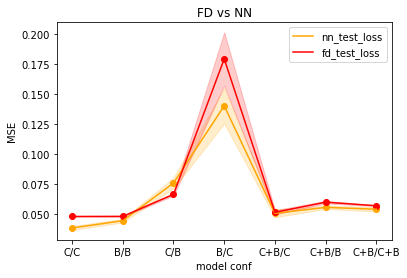

In [27]:
nn_mean = [nn_losses[i][0] for i in nn_losses.keys()]
nn_std = [nn_losses[i][1] for i in nn_losses.keys()]

fd_mean = [fd_losses[i][0] for i in fd_losses.keys()]
fd_std = [fd_losses[i][1] for i in fd_losses.keys()]

fig, ax = plt.subplots()
ax.fill_between(range(len(nn_std)), [nn_mean[i]+nn_std[i] for i in range(len(nn_std))], [nn_mean[i]-nn_std[i] for i in range(len(nn_std))], alpha=0.2, color='orange')
ax.plot(nn_mean, label='nn_test_loss', c='orange')
ax.scatter(range(len(nn_std)), nn_mean, c='orange')

ax.fill_between(range(len(fd_std)), [fd_mean[i]+fd_std[i] for i in range(len(fd_std))], [fd_mean[i]-fd_std[i] for i in range(len(fd_std))], alpha=0.2, color='red')
ax.plot(fd_mean, label='fd_test_loss', c='red')
ax.scatter(range(len(fd_mean)), fd_mean, c='red')
plt.legend()
ax.set_ylabel('MSE')
ax.set_xlabel('model conf')
ax.set_xticks(range(len(nn_mean)), labels=['C/C', 'B/B', 'C/B', 'B/C', 'C+B/C', 'C+B/B', 'C+B/C+B'])
plt.title('FD vs NN')
plt.show()

# TRYING A SMALLER NET FOR FD

In [28]:
import tensorflow as tf


class FD_Network(tf.keras.Model):
    """
    network to train a model approximating the Weidmann Model on given data
    """
    def __init__(self):
        """
        initialize the network, very simple feed forward network with 3 parameter outputs
        """
        super(FD_Network, self).__init__()
        # output layers producing the 3 parameters of the FD
        self.desired_speed = tf.keras.layers.Dense(1)
        self.pedestrian_size = tf.keras.layers.Dense(1)
        self.time_gap = tf.keras.layers.Dense(1)
        self.FD_model_parameters = {'t': [], 'l': [], 'v0': []}
        self.mse = -1

    def call(self, mean_spacing):
        """
        execute the feedforward, create the fd function from the parameters, return the predicted speed
        :param mean_spacing: only input of the net
        :return: predicted speed
        """
        v0 = self.desired_speed(mean_spacing)
        v0 = tf.keras.activations.softplus(v0)  # if bidirectional not needed!
        l = self.pedestrian_size(mean_spacing)
        l = tf.keras.activations.softplus(l)
        t = self.time_gap(mean_spacing)
        t = tf.keras.activations.softplus(t)
        self.FD_model_parameters['t'].append(tf.math.reduce_mean(t))
        self.FD_model_parameters['l'].append(tf.math.reduce_mean(l))
        self.FD_model_parameters['v0'].append(tf.math.reduce_mean(v0))
        return v0 * (1 - tf.exp((l - mean_spacing) / (v0 * t)))

In [29]:
# trying corridor85/corridor85
task = ["corridor_85"]
nn_losses, fd_losses = train_both_models(task_train=task, task_test=task)

Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.1809 - val_loss: 0.1246
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1556 - val_loss: 0.1058
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1351 - val_loss: 0.0914
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1189 - val_loss: 0.0805
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1062 - val_loss: 0.0721
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0962 - val_loss: 0.0658
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0883 - val_loss: 0.0613
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0823 - val_loss: 0.0579
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0775 - val_loss: 0.0556
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0738 - val_loss: 0.0539

25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0447
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0448
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0447
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0448
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0448
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0540 - val_loss: 0.0526
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0526
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0527
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0527
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0527
Epoch 6/1

25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0513
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0512
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0513
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0514
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0513
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0513
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0513
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0512
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0512
Epoch 33/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0491 - val_loss: 0.0512
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0502
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0502
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0502
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0502
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0502
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0492 - val_loss: 0.0502
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0497 - val_loss: 0.0484
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0484
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0485
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0484
Epoch 5/10

Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0411
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0411
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0411
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0411
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0411
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0509 - val_loss: 0.0464
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0463
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0509 - val_loss: 0.0463
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0464
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.04

25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0476
Epoch 17/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0475
Epoch 18/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0476
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0475
Epoch 20/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0476
Epoch 21/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0475
Epoch 22/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0475
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0475
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0476
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0516 - val_loss: 0.0475
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0501
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0501
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0501
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0501
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0502
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0501
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0501
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0501
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0501
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0555 - val_loss: 0.0501
Epoch 13/1

Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0569
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0569
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0569
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0504 - val_loss: 0.0569
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0527 - val_loss: 0.0478
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0479
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0480
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0480
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0480
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0

25/25 [==============================] - 0s 2ms/step - loss: 0.0490 - val_loss: 0.0498
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0496 - val_loss: 0.0470
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0471
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0471
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0471
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0471
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0471
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0472
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0471
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0471
Epoch 10/1000

Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0529
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0529
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0529
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0529
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0528
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0528
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0529
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0477 - val_loss: 0.0508
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0508
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.05

25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0449
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0449
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0449
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0449
Epoch 1/1000
25/25 [==============================] - 1s 6ms/step - loss: 0.0495 - val_loss: 0.0513
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0512
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0514
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0513
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0513
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0513
Epoch 7/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0439
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0439
Epoch 44/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0466 - val_loss: 0.0439
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0439
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0439
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0439
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0439
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0439
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0439
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0439
Epoc

Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0514
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0514
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0546 - val_loss: 0.0514
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0513
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0514
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0513
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0514
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0514
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0514
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0545 - val_loss: 0.0

25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0531
Epoch 19/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0517 - val_loss: 0.0533
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0521 - val_loss: 0.0514
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0515
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0516
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0515
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0516
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0515
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0516
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0516
Epoch 9/1000

Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0492
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0492
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0492
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0493
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0494 - val_loss: 0.0544
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0543
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0544
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0544
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.0544
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0493 - val_loss: 0.054

25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0569
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0569
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0570
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.2238 - val_loss: 0.2218
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1684 - val_loss: 0.1764
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1355 - val_loss: 0.1514
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1174 - val_loss: 0.1351
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1054 - val_loss: 0.1235
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0966 - val_loss: 0.1139
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0894 - val_loss: 0.1062
Epoch 8/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0478
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0476
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0476
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0475
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0415 - val_loss: 0.0474
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0472
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0471
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0470
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0469
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0467
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0429
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0429
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0428
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0430
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0428
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0429
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0429
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0426
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0426
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0418
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0417
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0416
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0416
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0418
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0416
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0416
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0417
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0415
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0406
Epoch 320/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0404
Epoch 321/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0407
Epoch 322/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0404
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0404
Epoch 324/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0408
Epoch 325/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0404
Epoch 326/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0405
Epoch 327/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0403
Epoch 328/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0382
Epoch 400/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0380
Epoch 401/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0327 - val_loss: 0.0381
Epoch 402/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0380
Epoch 403/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0379
Epoch 404/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0380
Epoch 405/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0379
Epoch 406/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0380
Epoch 407/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0379
Epoch 408/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0358
Epoch 480/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0359
Epoch 481/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0358
Epoch 482/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0358
Epoch 483/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0358
Epoch 484/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0356
Epoch 485/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0357
Epoch 486/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0357
Epoch 487/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0356
Epoch 488/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0343
Epoch 560/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0343
Epoch 561/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0341
Epoch 562/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0340
Epoch 563/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0342
Epoch 564/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0342
Epoch 565/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0342
Epoch 566/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0300 - val_loss: 0.0341
Epoch 567/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0340
Epoch 568/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0333
Epoch 640/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0333
Epoch 641/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0331
Epoch 642/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0332
Epoch 643/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0333
Epoch 644/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0333
Epoch 645/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0333
Epoch 646/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0332
Epoch 647/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0332
Epoch 648/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0565 - val_loss: 0.0610
Epoch 23/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0608
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0559 - val_loss: 0.0607
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0557 - val_loss: 0.0605
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0603
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0554 - val_loss: 0.0602
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0553 - val_loss: 0.0600
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0551 - val_loss: 0.0600
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0550 - val_loss: 0.0597
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0549 - val_loss: 0.0597
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0518
Epoch 104/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0518
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0518
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0517
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0477 - val_loss: 0.0514
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0513
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0514
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0474 - val_loss: 0.0513
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.0509
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0472 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0438
Epoch 184/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0439
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0434
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0433
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0434
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0433
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0433
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0430
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0432
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0397
Epoch 264/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0397
Epoch 265/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0398
Epoch 266/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0400
Epoch 267/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0396
Epoch 268/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0397
Epoch 269/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0398
Epoch 270/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0395
Epoch 271/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.0396
Epoch 272/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0352 - val_loss: 0.

25/25 [==============================] - 0s 5ms/step - loss: 0.0342 - val_loss: 0.0374
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0338 - val_loss: 0.0377
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0377
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0380
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0381
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0382
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0381
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0381
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0381
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0384
Epoch 11/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0469 - val_loss: 0.0425
Epoch 38/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0423
Epoch 39/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0420
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0464 - val_loss: 0.0421
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0416
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0417
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0459 - val_loss: 0.0417
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0414
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0412
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0412
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0367
Epoch 119/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0362
Epoch 120/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0363
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0393 - val_loss: 0.0364
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0362
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0362
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0392 - val_loss: 0.0362
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0363
Epoch 126/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0362
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0339
Epoch 199/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0336
Epoch 200/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0337
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0338
Epoch 202/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0337
Epoch 203/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0336
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0335
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0336
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0336
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0322
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0337 - val_loss: 0.0319
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0320
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.0329 - val_loss: 0.0361
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0365
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0366
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0370
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0372
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0371
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0373
Epoch 8/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0549
Epoch 69/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0549
Epoch 70/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0546
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0548
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0547
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0546
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0545
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0545
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0546
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.0543
Epoc

Epoch 149/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0390 - val_loss: 0.0502
Epoch 150/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0500
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0500
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0389 - val_loss: 0.0499
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0388 - val_loss: 0.0499
Epoch 154/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0386 - val_loss: 0.0497
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0495
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0495
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0385 - val_loss: 0.0497
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0384

25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0443
Epoch 230/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0442
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0342 - val_loss: 0.0442
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0440
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0441
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.0439
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0441
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0339 - val_loss: 0.0437
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0341 - val_loss: 0.0437
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0340 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0398
Epoch 310/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0398
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0396
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0397
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0397
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0311 - val_loss: 0.0395
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0312 - val_loss: 0.0396
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0394
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0396
Epoch 318/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0377
Epoch 390/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0375
Epoch 391/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0375
Epoch 392/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0376
Epoch 393/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0375
Epoch 394/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0375
Epoch 395/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0375
Epoch 396/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0374
Epoch 397/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0373
Epoch 398/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0301
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0303
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0304
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0305
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0306
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0306
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0307
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0308
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.9699 - val_loss: 0.8698
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8385 - val_loss: 0.7536
Epoch 3/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0535
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0535
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0534
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0533
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0533
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0496 - val_loss: 0.0533
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0532
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0532
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0532
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0532
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0457 - val_loss: 0.0499
Epoch 155/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0499
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0456 - val_loss: 0.0498
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0497
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0455 - val_loss: 0.0497
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0454 - val_loss: 0.0496
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0496
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0496
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0452 - val_loss: 0.0494
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0451 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0466
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0465
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0402 - val_loss: 0.0465
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0401 - val_loss: 0.0465
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0462
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0463
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0463
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0400 - val_loss: 0.0463
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0398 - val_loss: 0.0462
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0437
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0436
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0438
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0376 - val_loss: 0.0442
Epoch 318/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0437
Epoch 319/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0437
Epoch 320/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.0436
Epoch 321/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0375 - val_loss: 0.0437
Epoch 322/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0437
Epoch 323/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0374 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0381
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0382
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0382
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0383
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0383
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0385
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 1.1906 - val_loss: 1.1759
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 1.0114 - val_loss: 1.0018
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.8539 - val_loss: 0.8436
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7156 - val_loss: 0.7102
Epoch 5/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0570 - val_loss: 0.0449
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0569 - val_loss: 0.0449
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0568 - val_loss: 0.0447
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0446
Epoch 80/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0448
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0564 - val_loss: 0.0445
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0563 - val_loss: 0.0443
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0562 - val_loss: 0.0446
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0561 - val_loss: 0.0443
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0560 - val_loss: 0.0446
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0470 - val_loss: 0.0390
Epoch 157/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0468 - val_loss: 0.0391
Epoch 158/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0467 - val_loss: 0.0393
Epoch 159/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0466 - val_loss: 0.0390
Epoch 160/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0391
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0465 - val_loss: 0.0384
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0462 - val_loss: 0.0392
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0389
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0460 - val_loss: 0.0387
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0458 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0399 - val_loss: 0.0363
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0355
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0397 - val_loss: 0.0362
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0359
Epoch 240/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0396 - val_loss: 0.0360
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0359
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0356
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0395 - val_loss: 0.0357
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.0364
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0394 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0532
Epoch 24/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0577 - val_loss: 0.0519
Epoch 25/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0566 - val_loss: 0.0507
Epoch 26/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0556 - val_loss: 0.0497
Epoch 27/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0547 - val_loss: 0.0488
Epoch 28/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0539 - val_loss: 0.0480
Epoch 29/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0472
Epoch 30/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0525 - val_loss: 0.0467
Epoch 31/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0461
Epoch 32/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0513 - val_loss: 0.0455
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0360
Epoch 105/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0361
Epoch 106/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0361
Epoch 107/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0360
Epoch 108/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0408 - val_loss: 0.0359
Epoch 109/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0359
Epoch 110/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0359
Epoch 111/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0358
Epoch 112/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0359
Epoch 113/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0368 - val_loss: 0.0340
Epoch 185/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0341
Epoch 186/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0367 - val_loss: 0.0341
Epoch 187/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0340
Epoch 188/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0340
Epoch 189/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0340
Epoch 190/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0339
Epoch 191/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0366 - val_loss: 0.0340
Epoch 192/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0342
Epoch 193/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0324
Epoch 1/1000
25/25 [==============================] - 0s 5ms/step - loss: 0.1440 - val_loss: 0.1575
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1197 - val_loss: 0.1330
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1052 - val_loss: 0.1190
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0959 - val_loss: 0.1092
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0886 - val_loss: 0.1023
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0830 - val_loss: 0.0965
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0783 - val_loss: 0.0919
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0741 - val_loss: 0.0879
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0708 - val_loss: 0.0848
Epoch 10/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0534
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0537
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0534
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0533
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0537
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0533
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0533
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0530
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0531
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0529
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0491
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0490
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0491
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0488
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0495
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0487
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0489
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0486
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0491
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0373 - val_loss: 0.0333
Epoch 10/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0373 - val_loss: 0.0333
Epoch 11/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0373 - val_loss: 0.0333
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0360 - val_loss: 0.0393
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0358 - val_loss: 0.0396
Epoch 3/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0356 - val_loss: 0.0393
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0400
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0401
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0396
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0402
Epoch 8/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0543 - val_loss: 0.0674
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0540 - val_loss: 0.0672
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0538 - val_loss: 0.0672
Epoch 49/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0669
Epoch 50/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0532 - val_loss: 0.0668
Epoch 51/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0665
Epoch 52/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0665
Epoch 53/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0665
Epoch 54/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0664
Epoch 55/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0520 - val_loss: 0.0661
Epoc

Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0583
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0583
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0582
Epoch 130/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0580
Epoch 131/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0578
Epoch 132/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0421 - val_loss: 0.0580
Epoch 133/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0420 - val_loss: 0.0578
Epoch 134/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0576
Epoch 135/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0417 - val_loss: 0.0577
Epoch 136/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416

25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0527
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0528
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0524
Epoch 210/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0527
Epoch 211/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0524
Epoch 212/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0523
Epoch 213/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0525
Epoch 214/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0524
Epoch 215/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0524
Epoch 216/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0498
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0494
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0496
Epoch 290/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0326 - val_loss: 0.0495
Epoch 291/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0492
Epoch 292/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0325 - val_loss: 0.0492
Epoch 293/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0496
Epoch 294/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0493
Epoch 295/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0492
Epoch 296/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0479
Epoch 368/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0478
Epoch 369/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0306 - val_loss: 0.0480
Epoch 370/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0479
Epoch 371/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0476
Epoch 372/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0304 - val_loss: 0.0476
Epoch 373/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0479
Epoch 374/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0479
Epoch 375/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0478
Epoch 376/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0930 - val_loss: 0.0933
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0842 - val_loss: 0.0851
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0776 - val_loss: 0.0787
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0725 - val_loss: 0.0741
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0689 - val_loss: 0.0707
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0659 - val_loss: 0.0684
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0636 - val_loss: 0.0666
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0618 - val_loss: 0.0648
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0602 - val_loss: 0.0635
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0589 - val_loss: 0.0621
Epoch 13/1

25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0452
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0450
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0449
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0422 - val_loss: 0.0447
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0444
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0443
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0418 - val_loss: 0.0441
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0416 - val_loss: 0.0440
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0414 - val_loss: 0.0438
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0436
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0337
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0336 - val_loss: 0.0336
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0335 - val_loss: 0.0336
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0334 - val_loss: 0.0335
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0334
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0332
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0334
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0333 - val_loss: 0.0332
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0331 - val_loss: 0.0332
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0330 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0303 - val_loss: 0.0304
Epoch 245/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0303
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0304
Epoch 247/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0303
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0303
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.0303
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0304
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0303
Epoch 252/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0303
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0302 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0288 - val_loss: 0.0314
Epoch 1/1000
25/25 [==============================] - 1s 16ms/step - loss: 0.0295 - val_loss: 0.0301
Epoch 2/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0291 - val_loss: 0.0303
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0304
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0306
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0309
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0290 - val_loss: 0.0309
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0289 - val_loss: 0.0311
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0288 - val_loss: 0.0315
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0287 - val_loss: 0.0313
Epoch 10/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0531 - val_loss: 0.0493
Epoch 71/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0529 - val_loss: 0.0492
Epoch 72/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0528 - val_loss: 0.0491
Epoch 73/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0527 - val_loss: 0.0489
Epoch 74/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0526 - val_loss: 0.0488
Epoch 75/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0524 - val_loss: 0.0487
Epoch 76/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0523 - val_loss: 0.0486
Epoch 77/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0522 - val_loss: 0.0485
Epoch 78/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0521 - val_loss: 0.0485
Epoch 79/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0519 - val_loss: 0.0483
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0426 - val_loss: 0.0427
Epoch 151/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0425 - val_loss: 0.0426
Epoch 152/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0424 - val_loss: 0.0426
Epoch 153/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0423 - val_loss: 0.0425
Epoch 154/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0421 - val_loss: 0.0424
Epoch 155/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0420 - val_loss: 0.0424
Epoch 156/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0419 - val_loss: 0.0423
Epoch 157/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0418 - val_loss: 0.0423
Epoch 158/1000
25/25 [==============================] - 0s 4ms/step - loss: 0.0418 - val_loss: 0.0422
Epoch 159/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0416 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0355 - val_loss: 0.0383
Epoch 231/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0382
Epoch 232/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0381
Epoch 233/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0354 - val_loss: 0.0382
Epoch 234/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0380
Epoch 235/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0353 - val_loss: 0.0380
Epoch 236/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0380
Epoch 237/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0382
Epoch 238/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0380
Epoch 239/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0324 - val_loss: 0.0361
Epoch 311/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0360
Epoch 312/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0359
Epoch 313/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0359
Epoch 314/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0361
Epoch 315/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0323 - val_loss: 0.0360
Epoch 316/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0358
Epoch 317/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0322 - val_loss: 0.0359
Epoch 318/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.0358
Epoch 319/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0321 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0348
Epoch 391/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0310 - val_loss: 0.0347
Epoch 392/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0310 - val_loss: 0.0347
Epoch 393/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0346
Epoch 394/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0346
Epoch 395/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0346
Epoch 396/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0348
Epoch 397/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0346
Epoch 398/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0345
Epoch 399/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0300
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0310 - val_loss: 0.0302
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0301
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0302
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0304
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0309 - val_loss: 0.0305
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0308 - val_loss: 0.0306
Epoch 1/1000
25/25 [==============================] - 2s 6ms/step - loss: 0.0303 - val_loss: 0.0331
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0301 - val_loss: 0.0334
Epoch 3/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0299 - val_loss: 0.0338
Epoch 4/100

25/25 [==============================] - 0s 2ms/step - loss: 0.0442 - val_loss: 0.0514
Epoch 40/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0440 - val_loss: 0.0514
Epoch 41/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0512
Epoch 42/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0510
Epoch 43/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0510
Epoch 44/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0508
Epoch 45/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0506
Epoch 46/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0432 - val_loss: 0.0504
Epoch 47/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0430 - val_loss: 0.0504
Epoch 48/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0429 - val_loss: 0.0503
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0351 - val_loss: 0.0434
Epoch 121/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0350 - val_loss: 0.0431
Epoch 122/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0349 - val_loss: 0.0431
Epoch 123/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0348 - val_loss: 0.0429
Epoch 124/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0428
Epoch 125/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0347 - val_loss: 0.0429
Epoch 126/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0345 - val_loss: 0.0425
Epoch 127/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0344 - val_loss: 0.0426
Epoch 128/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.0425
Epoch 129/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0343 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0373
Epoch 201/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0373
Epoch 202/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0297 - val_loss: 0.0372
Epoch 203/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0298 - val_loss: 0.0373
Epoch 204/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0372
Epoch 205/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0296 - val_loss: 0.0370
Epoch 206/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0371
Epoch 207/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0372
Epoch 208/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.0370
Epoch 209/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0295 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0350
Epoch 281/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0350
Epoch 282/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0351
Epoch 283/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0349
Epoch 284/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0350
Epoch 285/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0350
Epoch 286/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0350
Epoch 287/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.0349
Epoch 288/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0280 - val_loss: 0.0348
Epoch 289/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0279 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0342
Epoch 361/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0342
Epoch 362/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0343
Epoch 363/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0343
Epoch 364/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0341
Epoch 365/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0342
Epoch 366/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0343
Epoch 367/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0276 - val_loss: 0.0342
Epoch 368/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0275 - val_loss: 0.0342
Epoch 369/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0275 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0294
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0281 - val_loss: 0.0294
Epoch 1/1000
25/25 [==============================] - 0s 7ms/step - loss: 0.8153 - val_loss: 0.6195
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.7010 - val_loss: 0.5265
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6005 - val_loss: 0.4467
Epoch 4/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.5125 - val_loss: 0.3788
Epoch 5/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.4387 - val_loss: 0.3209
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3760 - val_loss: 0.2731
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3248 - val_loss: 0.2321
Epoch 8/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.2812 - val_loss: 0.1984
Epoch 9/1000

25/25 [==============================] - 0s 2ms/step - loss: 0.0487 - val_loss: 0.0450
Epoch 81/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0486 - val_loss: 0.0451
Epoch 82/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0485 - val_loss: 0.0450
Epoch 83/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0484 - val_loss: 0.0449
Epoch 84/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0483 - val_loss: 0.0450
Epoch 85/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0445
Epoch 86/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0481 - val_loss: 0.0446
Epoch 87/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0446
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0449
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0445
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0394
Epoch 161/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0390
Epoch 162/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0393
Epoch 163/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0396
Epoch 164/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0388
Epoch 165/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0405 - val_loss: 0.0386
Epoch 166/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0404 - val_loss: 0.0388
Epoch 167/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0403 - val_loss: 0.0392
Epoch 168/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0402 - val_loss: 0.0385
Epoch 169/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0401 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0345
Epoch 241/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0345
Epoch 242/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0344
Epoch 243/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0346
Epoch 244/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.0340
Epoch 245/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0357 - val_loss: 0.0347
Epoch 246/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.0348
Epoch 247/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0356 - val_loss: 0.0341
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0356 - val_loss: 0.0344
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0357 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.3294 - val_loss: 0.3052
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2689 - val_loss: 0.2463
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2198 - val_loss: 0.1991
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1807 - val_loss: 0.1636
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1507 - val_loss: 0.1359
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1276 - val_loss: 0.1147
Epoch 12/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1094 - val_loss: 0.0995
Epoch 13/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0960 - val_loss: 0.0881
Epoch 14/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0860 - val_loss: 0.0797
Epoch 15/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0787 - val_loss: 0.0736
Epoch 1

25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0533
Epoch 88/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0501 - val_loss: 0.0532
Epoch 89/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0499 - val_loss: 0.0531
Epoch 90/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0531
Epoch 91/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0498 - val_loss: 0.0530
Epoch 92/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0497 - val_loss: 0.0529
Epoch 93/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0495 - val_loss: 0.0529
Epoch 94/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0526
Epoch 95/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0527
Epoch 96/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0494 - val_loss: 0.0524
Epoc

25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0480
Epoch 168/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0438 - val_loss: 0.0480
Epoch 169/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0479
Epoch 170/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0436 - val_loss: 0.0478
Epoch 171/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0435 - val_loss: 0.0477
Epoch 172/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0477
Epoch 173/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - val_loss: 0.0475
Epoch 174/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0475
Epoch 175/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0433 - val_loss: 0.0473
Epoch 176/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0431 - val_loss: 0.

25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0432
Epoch 248/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0383 - val_loss: 0.0435
Epoch 249/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0431
Epoch 250/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0430
Epoch 251/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0382 - val_loss: 0.0429
Epoch 252/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0381 - val_loss: 0.0431
Epoch 253/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0429
Epoch 254/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0431
Epoch 255/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.0430
Epoch 256/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0378 - val_loss: 0.

Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0341
Epoch 11/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0342
Epoch 1/1000
25/25 [==============================] - 0s 6ms/step - loss: 0.0370 - val_loss: 0.0335
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0365 - val_loss: 0.0335
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0364 - val_loss: 0.0336
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0338
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0342
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0340
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0342
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.034

25/25 [==============================] - 0s 2ms/step - loss: 0.0482 - val_loss: 0.0492
Epoch 58/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0480 - val_loss: 0.0490
Epoch 59/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0479 - val_loss: 0.0488
Epoch 60/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0478 - val_loss: 0.0488
Epoch 61/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0477 - val_loss: 0.0488
Epoch 62/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0488
Epoch 63/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0476 - val_loss: 0.0487
Epoch 64/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0475 - val_loss: 0.0487
Epoch 65/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0484
Epoch 66/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0473 - val_loss: 0.0484
Epoc

Epoch 138/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0413 - val_loss: 0.0439
Epoch 139/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0412 - val_loss: 0.0438
Epoch 140/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0411 - val_loss: 0.0439
Epoch 141/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0410 - val_loss: 0.0437
Epoch 142/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0409 - val_loss: 0.0436
Epoch 143/1000
25/25 [==============================] - 0s 3ms/step - loss: 0.0409 - val_loss: 0.0435
Epoch 144/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0436
Epoch 145/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0407 - val_loss: 0.0434
Epoch 146/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406 - val_loss: 0.0432
Epoch 147/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0406

25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0392
Epoch 219/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0392
Epoch 220/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0394
Epoch 221/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0362 - val_loss: 0.0391
Epoch 222/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0392
Epoch 223/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0361 - val_loss: 0.0391
Epoch 224/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0360 - val_loss: 0.0391
Epoch 225/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0363 - val_loss: 0.0389
Epoch 226/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0359 - val_loss: 0.0392
Epoch 227/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.0358 - val_loss: 0.

In [30]:
nn_losses, fd_losses

({'tr': (0.03306187155346076, 0.002843094005167847),
  'val': (0.034837357004483545, 0.0029919695050888684),
  'test': (0.03793311965468007, 0.001539501633504766)},
 {'tr': (0.0503042700390021, 0.002465895920440628),
  'val': (0.0505009228984515, 0.002501485600835767),
  'test': (0.04792090170575935, 0.00011191006210457865)})

nothing changes even making the net for fd simpler...

# TRYING REGULARIZATION EFFECTS

# TRYING TO GET RID OF MEAN SPACING